In [190]:
import digitalhub as dh
from scipy.stats import truncnorm

In [2]:
project_tourism = dh.get_or_create_project(name="overtourism")

In [5]:
contamezzi_df = project_tourism.get_dataitem("contamezzi").as_df()

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets_tourism_dh import *

In [7]:
START_DATE = "2022-01-01"
END_DATE = "2024-03-31"

LOC_ID_COMUNE_MOLVENO = "27"
LOC_TYPE_COMUNE_MOLVENO = "TN_MKT_AL_3"

In [8]:
def mapping_tmax_val(tmax):
    if tmax>=28:
        return "Caldo"
    elif tmax<=22:
        return "Freddo"
    else:
        return "Normale"
def mapping_tmin_val(tmax):
    if tmax>=16:
        return "Caldo"
    elif tmax<=10:
        return "Freddo"
    else:
        return "Normale"

In [15]:
meteotrentino_bollettino_df

,data,comune,ambito,meteo,tmin,tmax,probprec06-12,intprec06-12,probtemp06-12,probprec12-18,intprec12-18,probtemp12-18
0,2018-03-03,BASELGA DI PINE',TRENTO,Molto nuvoloso,-4,2,molto bassa,debole,--,molto bassa,debole,--
1,2018-03-03,CANAZEI,MADONNA,Molto nuvoloso,-6,4,molto bassa,debole,--,molto bassa,debole,--
2,2018-03-03,CAVALESE,FIEMME,Molto nuvoloso,-4,3,molto bassa,debole,--,molto bassa,debole,--
3,2018-03-03,FOLGARIA,ALTIPIANO,Molto nuvoloso,-3,2,molto bassa,debole,--,molto bassa,debole,--
4,2018-03-03,FONDO,VALDINON,Molto nuvoloso,-4,3,molto bassa,debole,--,molto bassa,debole,--
...,...,...,...,...,...,...,...,...,...,...,...,...
41408,2024-05-31,COMANO TERME,GARDA,Coperto con piogge moderate,12,15,alta,forte,bassa,alta,moderata,bassa
41409,2024-05-31,BEZZECCA,GARDA,Coperto con piogge moderate,11,14,alta,forte,bassa,alta,moderata,bassa
41410,2024-05-31,PIEVE DI BONO,MADONNA,Coperto con piogge moderate,13,16,alta,forte,bassa,alta,moderata,bassa
41411,2024-05-31,CENTA SAN NICOLO,ALTIPIANO,Coperto con piogge moderate,11,14,alta,forte,bassa,alta,moderata,bassa


# Data preparation

In [40]:
attendences_df = vodafone_attendences_df[
    (vodafone_attendences_df['date'] >= START_DATE) &
    (vodafone_attendences_df['date'] <= END_DATE) &
    (vodafone_attendences_df["value"] != 0) &
    (vodafone_attendences_df["userProfile"] != 'INHABITANT') &
    (vodafone_attendences_df["userProfile"] != 'COMMUTER') &
    (vodafone_attendences_df["locId"] == LOC_ID_COMUNE_MOLVENO) &
    (vodafone_attendences_df["locType"] == LOC_TYPE_COMUNE_MOLVENO) ]
attendences_df = attendences_df[['date','userProfile','value']]
attendences_df

,date,userProfile,value
2343,2022-01-01,TOURIST,16
2347,2022-01-01,TOURIST,16
2359,2022-01-01,TOURIST,4393
2360,2022-01-01,VISITOR,3130
2367,2022-01-01,TOURIST,45
...,...,...,...
4576319,2024-03-30,VISITOR,40
4576328,2024-03-30,TOURIST,864
4576329,2024-03-30,VISITOR,583
4581539,2024-03-31,TOURIST,930


In [44]:
########################################## Vodafone attendances
attendences_df = vodafone_attendences_df[
    (vodafone_attendences_df['date'] >= START_DATE) &
    (vodafone_attendences_df['date'] <= END_DATE) &
    (vodafone_attendences_df["value"] != 0) &
    (vodafone_attendences_df["userProfile"] != 'INHABITANT') &
    (vodafone_attendences_df["userProfile"] != 'COMMUTER') &
    (vodafone_attendences_df["locId"] == LOC_ID_COMUNE_MOLVENO) &
    (vodafone_attendences_df["locType"] == LOC_TYPE_COMUNE_MOLVENO) ]
attendences_df = attendences_df[['date','userProfile','value']]
attendences_df['weekday'] = pd.to_datetime(attendences_df.date).dt.weekday
attendences_df["is_weekend"] = attendences_df["weekday"].apply(lambda el: 1 if el==6 or el==5 else 0)
attendences_df['month'] = pd.to_datetime(attendences_df.date).dt.month
attendences_df['year'] = pd.to_datetime(attendences_df.date).dt.year

# tourists
tourist_attendences_df = attendences_df[attendences_df['userProfile'] == "TOURIST"][['date','value']].groupby('date').sum().reset_index()
tourist_attendences_df.rename(columns={"value": "presences_tourists"}, inplace=True)
tourist_attendences_df['weekday'] = pd.to_datetime(tourist_attendences_df.date).dt.weekday
tourist_attendences_df["is_weekend"] = tourist_attendences_df["weekday"].apply(lambda el: 1 if el==6 or el==5 else 0)
tourist_attendences_df['month'] = pd.to_datetime(tourist_attendences_df.date).dt.month
tourist_attendences_df['year'] = pd.to_datetime(tourist_attendences_df.date).dt.year
tourist_attendences_df['week'] = pd.to_datetime(tourist_attendences_df.date).dt.isocalendar().week
# excursionists
excursionist_attendences_df = attendences_df[attendences_df['userProfile'] == "VISITOR"][['date','value']].groupby('date').sum().reset_index()
excursionist_attendences_df.rename(columns={"value": "presences_excursionists"}, inplace=True)
excursionist_attendences_df['weekday'] = pd.to_datetime(excursionist_attendences_df.date).dt.weekday
excursionist_attendences_df["is_weekend"] = excursionist_attendences_df["weekday"].apply(lambda el: 1 if el==6 or el==5 else 0)
excursionist_attendences_df['month'] = pd.to_datetime(excursionist_attendences_df.date).dt.month
excursionist_attendences_df['year'] = pd.to_datetime(excursionist_attendences_df.date).dt.year
excursionist_attendences_df['week'] = pd.to_datetime(excursionist_attendences_df.date).dt.isocalendar().week

############################################# Weather in Molveno
meteo_df = meteotrentino_bollettino_df[
    (meteotrentino_bollettino_df["comune"].str.contains("MOLVENO")) &
    (meteotrentino_bollettino_df["data"] >= START_DATE) &
    (meteotrentino_bollettino_df["data"] <= END_DATE)
][['data', "tmax", "tmin", "probprec06-12", "probprec12-18"]]#.set_index('data')
meteo_df = meteo_df.rename(columns={"data": "date"})
meteo_df["tmax_group"] = meteo_df["tmax"].map(mapping_tmax_val)
meteo_df["tmin_group"] = meteo_df["tmin"].map(mapping_tmin_val)

############################################ Movimento turistico
#TODO

############################################  Merged dataset: Presences + Meteo
tourist_attendences_meteo_df = pd.merge(tourist_attendences_df, meteo_df,  how='outer').fillna(0)
excursionist_attendences_meteo_df = pd.merge(excursionist_attendences_df, meteo_df, how='outer').fillna(0)
tourist_attendences_meteo_df

,date,presences_tourists,weekday,is_weekend,month,year,week,tmax,tmin,probprec06-12,probprec12-18,tmax_group,tmin_group
0,2022-01-01,4550.0,5.0,1.0,1.0,2022.0,52,0.0,0.0,0,0,0,0
1,2022-01-02,5110.0,6.0,1.0,1.0,2022.0,52,0.0,0.0,0,0,0,0
2,2022-01-03,3643.0,0.0,0.0,1.0,2022.0,1,12.0,0.0,--,--,Freddo,Freddo
3,2022-01-04,3337.0,1.0,0.0,1.0,2022.0,1,0.0,0.0,0,0,0,0
4,2022-01-05,3255.0,2.0,0.0,1.0,2022.0,1,2.0,0.0,alta,bassa,Freddo,Freddo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,2023-11-16,0.0,0.0,0.0,0.0,0.0,0,10.0,-1.0,--,--,Freddo,Freddo
814,2023-11-20,0.0,0.0,0.0,0.0,0.0,0,11.0,2.0,--,--,Freddo,Freddo
815,2023-11-21,0.0,0.0,0.0,0.0,0.0,0,7.0,3.0,--,--,Freddo,Freddo
816,2023-11-22,0.0,0.0,0.0,0.0,0.0,0,7.0,0.0,--,--,Freddo,Freddo


In [45]:
meteo_df["probprec06-12"].unique()

array(['--', 'alta', 'molto bassa', 'bassa', 'media'], dtype=object)

In [46]:
tourist_attendences_df

,date,presences_tourists,weekday,is_weekend,month,year,week
0,2022-01-01,4550,5,1,1,2022,52
1,2022-01-02,5110,6,1,1,2022,52
2,2022-01-03,3643,0,0,1,2022,1
3,2022-01-04,3337,1,0,1,2022,1
4,2022-01-05,3255,2,0,1,2022,1
...,...,...,...,...,...,...,...
804,2024-03-27,111,2,0,3,2024,13
805,2024-03-28,275,3,0,3,2024,13
806,2024-03-29,667,4,0,3,2024,13
807,2024-03-30,881,5,1,3,2024,13


In [50]:
resulting_T_E = pd.concat([excursionist_attendences_meteo_df, tourist_attendences_meteo_df[["presences_tourists"]]], axis=1)
resulting_T_E["all"] = resulting_T_E["presences_tourists"].add(resulting_T_E["presences_excursionists"])
resulting_T_E = resulting_T_E[~resulting_T_E["presences_tourists"].isna()]
resulting_T_E[["presences_excursionists", "presences_tourists", "weekday", "month", "year", "tmax", "all"]] = resulting_T_E[["presences_excursionists", "presences_tourists", "weekday", "month", "year", "tmax", "all"]].astype("int")
resulting_T_E

,date,presences_excursionists,weekday,is_weekend,month,year,week,tmax,tmin,probprec06-12,probprec12-18,tmax_group,tmin_group,presences_tourists,all
0,2022-01-01,3130,5,1,1,2022,52,0,0.0,0,0,0,0,4550,7680
1,2022-01-02,2926,6,1,1,2022,52,0,0.0,0,0,0,0,5110,8036
2,2022-01-03,1757,0,0,1,2022,1,12,0.0,--,--,Freddo,Freddo,3643,5400
3,2022-01-04,1356,1,0,1,2022,1,0,0.0,0,0,0,0,3337,4693
4,2022-01-05,546,2,0,1,2022,1,2,0.0,alta,bassa,Freddo,Freddo,3255,3801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,2024-03-24,752,6,1,3,2024,12,10,-1.0,media,bassa,Freddo,Freddo,0,752
814,2024-03-25,325,0,0,3,2024,13,13,-3.0,molto bassa,molto bassa,Freddo,Freddo,0,325
815,2024-03-26,229,1,0,3,2024,13,0,0.0,0,0,0,0,0,229
816,2024-03-27,317,2,0,3,2024,13,11,7.0,alta,alta,Freddo,Freddo,0,317


In [51]:
resulting_T_E["probprec06-12"].value_counts()

probprec06-12
0              300
--             239
molto bassa    132
bassa           72
media           42
alta            33
Name: count, dtype: int64

In [52]:
resulting_T_E.dtypes

date                        object
presences_excursionists      int64
weekday                      int64
is_weekend                   int64
month                        int64
year                         int64
week                        UInt32
tmax                         int64
tmin                       float64
probprec06-12               object
probprec12-18               object
tmax_group                  object
tmin_group                  object
presences_tourists           int64
all                          int64
dtype: object

In [53]:
resulting_T_E["isweekend"] = resulting_T_E["weekday"].apply(lambda el: 1 if el==6 or el==5 else 0)
resulting_T_E[resulting_T_E["isweekend"]==0]

,date,presences_excursionists,weekday,is_weekend,month,year,week,tmax,tmin,probprec06-12,probprec12-18,tmax_group,tmin_group,presences_tourists,all,isweekend
2,2022-01-03,1757,0,0,1,2022,1,12,0.0,--,--,Freddo,Freddo,3643,5400,0
3,2022-01-04,1356,1,0,1,2022,1,0,0.0,0,0,0,0,3337,4693,0
4,2022-01-05,546,2,0,1,2022,1,2,0.0,alta,bassa,Freddo,Freddo,3255,3801,0
5,2022-01-06,2260,3,0,1,2022,1,0,0.0,0,0,0,0,3607,5867,0
6,2022-01-07,2201,4,0,1,2022,1,3,-5.0,--,--,Freddo,Freddo,3365,5566,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,2024-03-22,407,4,0,3,2024,12,16,-1.0,molto bassa,molto bassa,Freddo,Freddo,0,407,0
814,2024-03-25,325,0,0,3,2024,13,13,-3.0,molto bassa,molto bassa,Freddo,Freddo,0,325,0
815,2024-03-26,229,1,0,3,2024,13,0,0.0,0,0,0,0,0,229,0
816,2024-03-27,317,2,0,3,2024,13,11,7.0,alta,alta,Freddo,Freddo,0,317,0


<Axes: xlabel='date'>

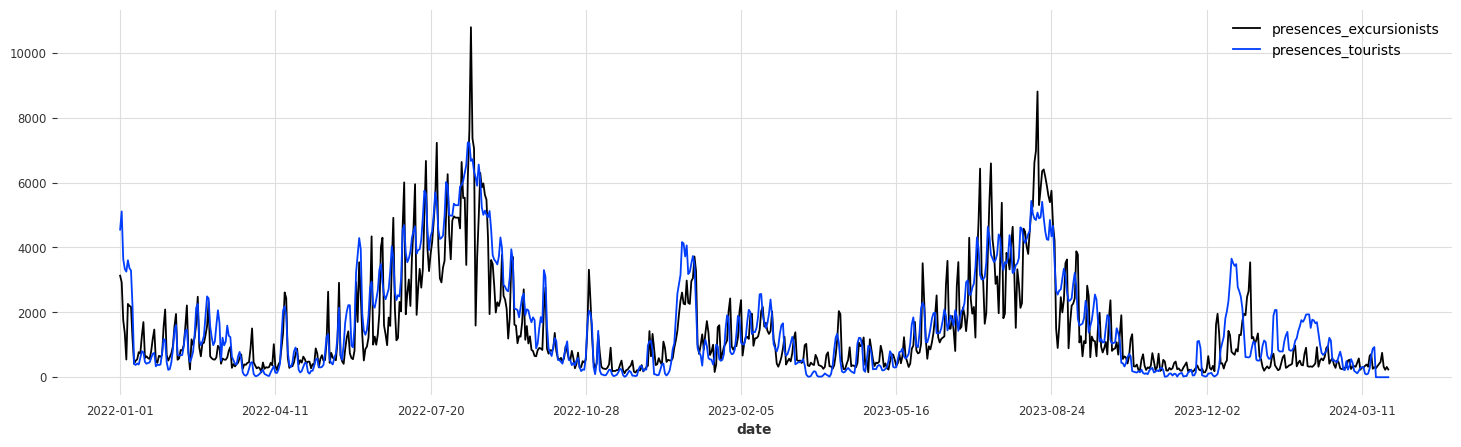

In [54]:
resulting_T_E[["date", "presences_excursionists", "presences_tourists"]].plot(x="date", figsize=(18, 5))

In [55]:
res

NameError: name 'res' is not defined

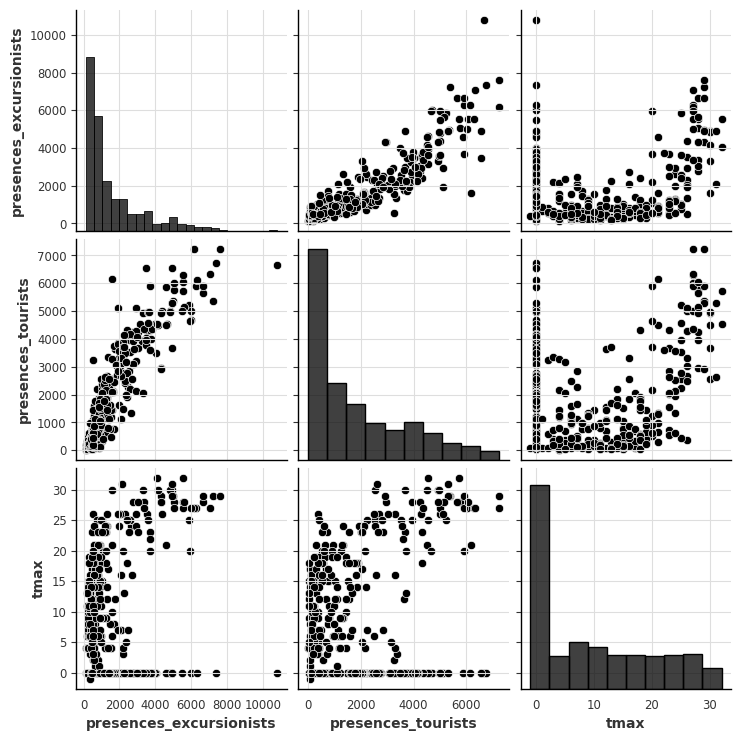

In [56]:
res = resulting_T_E.reset_index()
sns.pairplot(res[(res["date"] <= "2023-01-01") & (res["date"] <= "2023-12-31")][["presences_excursionists", "presences_tourists", "tmax"]])

# Statistical analysis

In [57]:
import statsmodels.api as sm

# Independent variables
resulting_T_E1 = resulting_T_E.reset_index()
resulting_T_E1["tmax"] = resulting_T_E1["tmax"].astype("int")
resulting_T_E1["tmin"] = resulting_T_E1["tmin"].astype("int")
X = resulting_T_E1[["presences_excursionists", "tmax", "tmin"]]

# Our dependent variable
y = resulting_T_E1.reset_index()[["presences_tourists"]]
# Add a constant to the independent value
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary statistics of the regression model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     presences_tourists   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     799.5
Date:                Tue, 10 Dec 2024   Prob (F-statistic):          4.33e-242
Time:                        10:28:12   Log-Likelihood:                -6620.0
No. Observations:                 818   AIC:                         1.325e+04
Df Residuals:                     814   BIC:                         1.327e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

# Method 1: Stratification
This involves  breaking up our data into homogeneous strata or groups where the confounding factor is constant.

Example:Divide one year into seazons according to the attendances, approximation[(December, January, February), (March, April, May), (June, July, August), (September, October, Novembre)]


In [58]:
from itertools import combinations

season_groups = range(1, 13)
results = list(combinations(season_groups, 3))
#results

(29, 33)
(2, 3)
(7, 8)


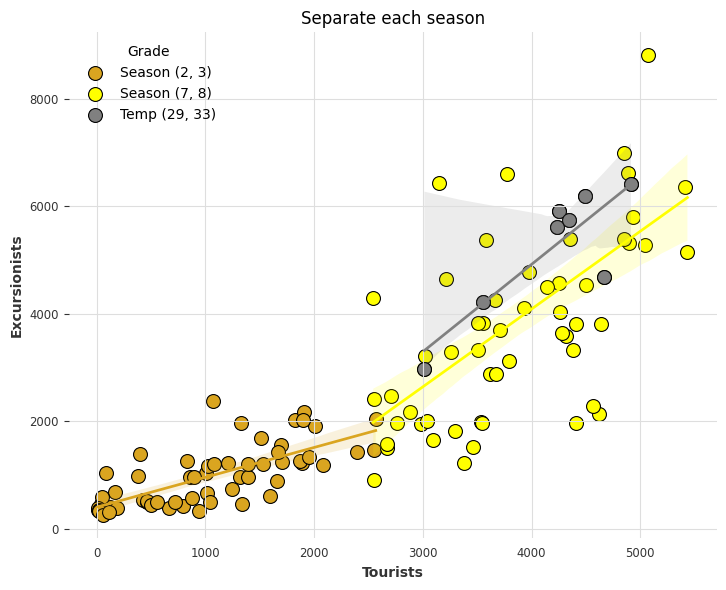

In [59]:
import matplotlib.colors as mcolors
import random

def season_granularity():
    pass

def temp_granularity():
    pass
    
def plot_seasons(year, 
                 season_groups=[(12, 1, 2), (3, 4, 5), (6, 7, 8), (9, 10, 11)],
                 temp_max_list=None
                 ):
    if year is not None:
        resulting_T_E_df = resulting_T_E[resulting_T_E["year"] == year]
    temp_dfs = []
    if temp_max_list is not None:
        for temp in temp_max_list:
            print(temp)            
            temp_dfs.append({"data": resulting_T_E_df[(resulting_T_E_df["tmax"] >= temp[0]) & (resulting_T_E_df["tmax"] <= temp[1])],
                             "temp": temp})
        #resulting_T_E_df = pd.concat(temp_dfs)
                     
    seasons_list = []
    for season in season_groups:
        print(season)
        seasons_list.append({"data": resulting_T_E_df[resulting_T_E_df['month'].isin(list(season))], 
                             "season": season})
    
    # Create the first plot (full dataset regression)
    plt.figure(figsize=(14, 6))    
    plt.subplot(1, 2, 2)  # Second plot
    #################### plot each season
    for season in seasons_list:
        color = random.choice(list(mcolors.CSS4_COLORS.keys()))
        sns.scatterplot(x='presences_tourists', y='presences_excursionists', data=season["data"], color=color, s=100, edgecolor='k', label=f'Season {season["season"]}')
        sns.regplot(x='presences_tourists', y='presences_excursionists', data=season["data"], scatter=False, color=color)

    for temp in temp_dfs:
        color = random.choice(list(mcolors.CSS4_COLORS.keys()))
        sns.scatterplot(x='presences_tourists', y='presences_excursionists', data=temp["data"], color=color, s=100, edgecolor='k', label=f'Temp {temp["temp"]}')
        sns.regplot(x='presences_tourists', y='presences_excursionists', data=temp["data"], scatter=False, color=color)
                    
    plt.title('Separate each season')
    plt.xlabel('Tourists')
    plt.ylabel('Excursionists')
    plt.legend(title='Grade')
    # Display the plots
    plt.tight_layout()
    plt.show()
plot_seasons(2023, season_groups=[(2, 3), (7,8)], 
             temp_max_list=[(29, 33)])

(12, 1, 2)
(3, 4, 5)
(6, 7, 8)
(9, 10, 11)


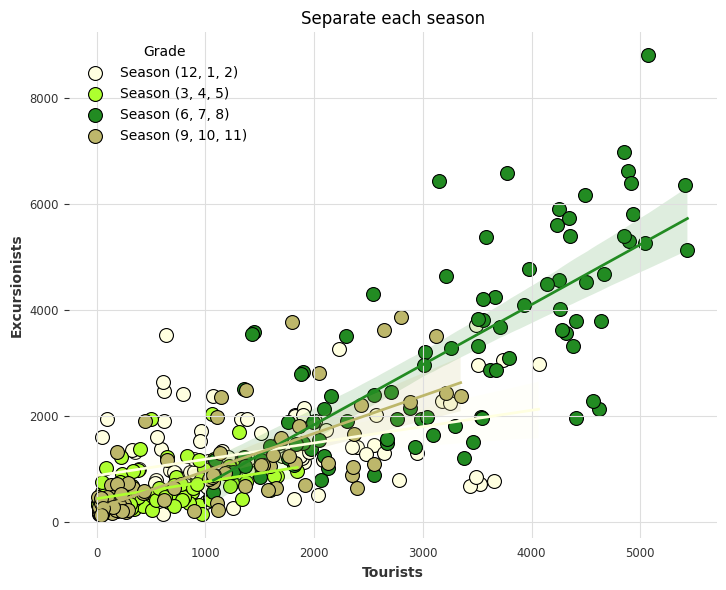

In [60]:
plot_seasons(2023)

(2, 3)
(7, 8)


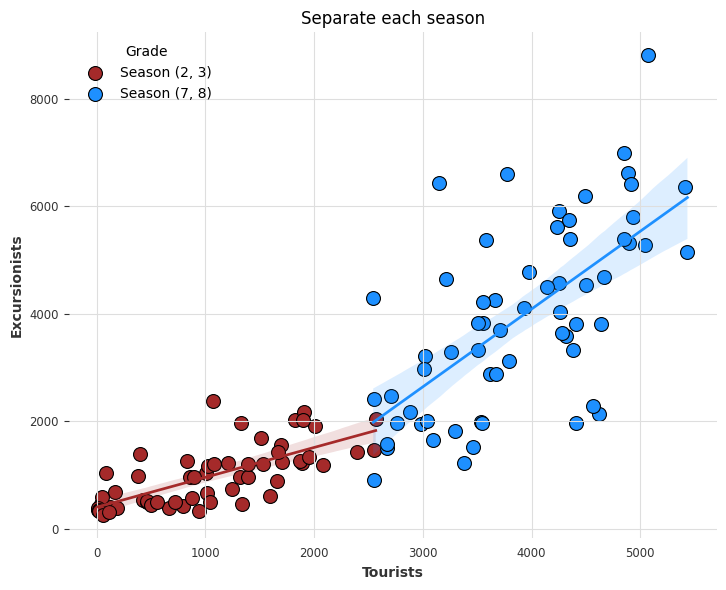

In [61]:
plot_seasons(2023, [(2, 3), (7,8)])

(1, 2, 3, 4)
(6, 7)
(8, 9)


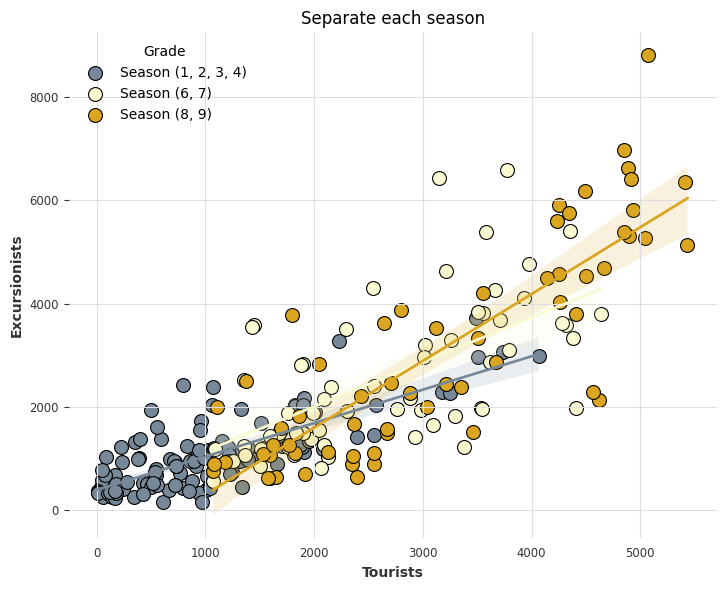

In [62]:
plot_seasons(2023, [(1,2,3,4), (6,7), (8,9)])

(12, 1, 2)
(3, 4, 5)
(6, 7, 8)
(9, 10, 11)


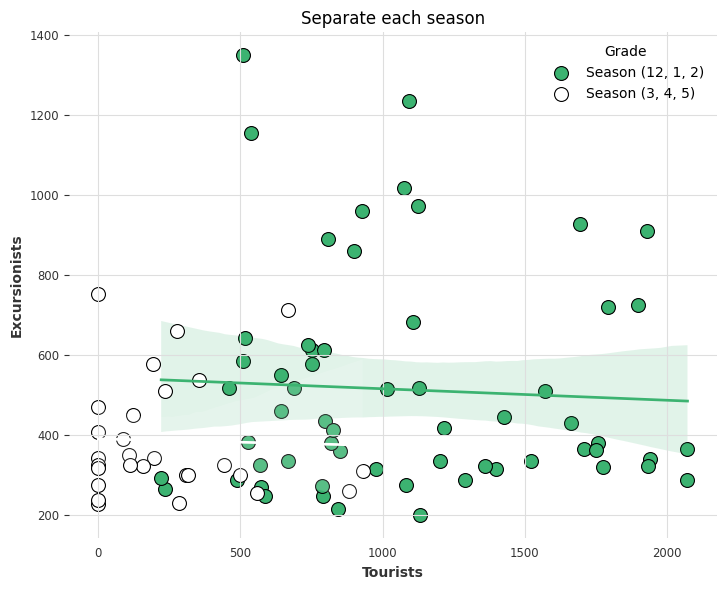

In [63]:
plot_seasons(2024)

# Method 2: Matching
In this method, for every entry in one group, you find a corresponding entry in the other group(s) that has the same or nearly the same value for the confounding variable(s). This method reduces the impact of confounding factors. Scikit-learn’s NearestNeighbors can be used to find matching pairs.

# Method 3: Multivariable analysis
You can use statistical methods that consider all variables at the same time. For instance, a regression analysis will allow you to see the effect of your independent variable on your dependent variable, while controlling for other variables. 
- libraries like statsmodels or scikit-learn to run multivariable regressions.

# Method 4: Propensity Score Matching (PSM)
This is a statistical matching technique that attempts to estimate the effect of a treatment, policy, or other intervention by accounting for the covariates that predict receiving the treatment. 
- causalinference and PyMatch are libraries that can be used to implement PSM

In [64]:
!pip -qq install pymatch causalinference

In [65]:
from pymatch.Matcher import Matcher
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from causalinference import CausalModel
from sklearn import preprocessing
from scipy import stats

In [66]:
# TODO standardize  - rescale the features

# Method 5: Instrumental Variable (IV) methods
An IV is a variable that is used in regression analysis when the model has endogeneity issues, such as measurement error, omitted variables, or simultaneity. It serves as a tool for providing consistent estimates of parameters. You can use the linearmodels library in Python for this approach.

In [68]:
import numpy as np
from statsmodels.datasets import grunfeld
data = grunfeld.load_pandas().data
data.year = data.year.astype(np.int64)
# MultiIndex, entity - time
data = data.set_index(['firm','year'])
from linearmodels import PanelOLS
mod = PanelOLS(data.invest, data[['value','capital']], entity_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
res

Dep. Variable:,invest,R-squared:,0.7667
Estimator:,PanelOLS,R-squared (Between):,0.8223
No. Observations:,220,R-squared (Within):,0.7667
Date:,"Tue, Dec 10 2024",R-squared (Overall):,0.8132
Time:,10:28:42,Log-likelihood,-1167.4
Cov. Estimator:,Clustered,,
,,F-statistic:,340.08
Entities:,11,P-value,0.0000
Avg Obs:,20.000,Distribution:,"F(2,207)"
Min Obs:,20.000,,
Max Obs:,20.000,F-statistic (robust):,31.490


In [69]:
resulting_T_E

,date,presences_excursionists,weekday,is_weekend,month,year,week,tmax,tmin,probprec06-12,probprec12-18,tmax_group,tmin_group,presences_tourists,all,isweekend
0,2022-01-01,3130,5,1,1,2022,52,0,0.0,0,0,0,0,4550,7680,1
1,2022-01-02,2926,6,1,1,2022,52,0,0.0,0,0,0,0,5110,8036,1
2,2022-01-03,1757,0,0,1,2022,1,12,0.0,--,--,Freddo,Freddo,3643,5400,0
3,2022-01-04,1356,1,0,1,2022,1,0,0.0,0,0,0,0,3337,4693,0
4,2022-01-05,546,2,0,1,2022,1,2,0.0,alta,bassa,Freddo,Freddo,3255,3801,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,2024-03-24,752,6,1,3,2024,12,10,-1.0,media,bassa,Freddo,Freddo,0,752,1
814,2024-03-25,325,0,0,3,2024,13,13,-3.0,molto bassa,molto bassa,Freddo,Freddo,0,325,0
815,2024-03-26,229,1,0,3,2024,13,0,0.0,0,0,0,0,0,229,0
816,2024-03-27,317,2,0,3,2024,13,11,7.0,alta,alta,Freddo,Freddo,0,317,0


# Model for Excursionists

In [70]:
resulting_T_E = resulting_T_E.reset_index(drop=True)

In [71]:
training_data_T_E = resulting_T_E[["presences_excursionists", "is_weekend", "month", "year", "tmax", "tmin"]]
training_data_T_E = training_data_T_E.astype("int")
training_data_T_E.head()

,presences_excursionists,is_weekend,month,year,tmax,tmin
0,3130,1,1,2022,0,0
1,2926,1,1,2022,0,0
2,1757,0,1,2022,12,0
3,1356,0,1,2022,0,0
4,546,0,1,2022,2,0


In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import f_regression

In [73]:
features = ['is_weekend', 'month', 'tmax', 'year', 'tmin']
target = ["presences_excursionists"]

In [74]:
models_metrics = []

In [75]:
class PCAConfig:
    def __init__(self, is_pca_enabled, num_components):
        self._is_pca_enabled = is_pca_enabled
        self._num_components = num_components   
        
    def is_enabled(self):
        return self._is_pca_enabled
        
    def get_nr_components(self):
        return self._num_components
    

In [76]:
X = training_data_T_E.loc[:, features].values
y = training_data_T_E.loc[:, target].values
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=0)

def define_baseline_regressor(training_data_T_E, features, target, pca_config, name="baseline model excursionist"):
    # Step 1: Train test split
    X = training_data_T_E.loc[:, features].values
    y = training_data_T_E.loc[:, target].values
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=0)
    
    # Step 2: Standardization
    std_scaler = StandardScaler()
    X_train = std_scaler.fit_transform(X_train)
    X_test = std_scaler.transform(X_test)
    
    # Step 3: Apply PCA transformation
    if pca_config.is_enabled():
        pca = PCA(n_components=pca_config.get_nr_components())
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
        print(f"PCA Explained variance : {pca.explained_variance_ratio_}")

        
    # Step 4: Fitting Linear Regression to the training set
    linear_regressor = LinearRegression()
    linear_regressor.fit(X_train, y_train)
        
    # Step 5: Prediction and accuracy evaluation
    y_predictions = linear_regressor.predict(X_test)
    r2 = r2_score(y_test, y_predictions)
    rmse = np.sqrt(mean_squared_error(y_test, y_predictions))
    mae = mean_absolute_error(y_test, y_predictions)
    print(f"Model Evaluation Metrics: r2_score: {r2},  root mean squared error: {rmse}, mean absolute error: {mae}")
    models_metrics.append({"name": name, "r2_score": r2, "rmse": rmse, "mae": mae})
    return linear_regressor
    
pca_config = PCAConfig(True, 4)
linear_regressor = define_baseline_regressor(training_data_T_E, features, target, pca_config)

PCA Explained variance : [0.39555529 0.22942638 0.19764093 0.14641112]
Model Evaluation Metrics: r2_score: 0.22269405550653876,  root mean squared error: 1331.1208429658718, mean absolute error: 959.516800794908


In [77]:
f_statistic, p_values = f_regression(X_train, y_train)
f_statistic, p_values

(array([ 39.78841111,  10.70602761,  76.87171722,  14.0958866 ,
        119.75907857]),
 array([5.22288418e-10, 1.12419867e-03, 1.57793510e-17, 1.89241319e-04,
        1.05041240e-25]))

In [78]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator= linear_regressor , step = 1) 
fit = rfe.fit(X_train, y_train)
# It uses the model accuracy to identify which features (and combination of features) contribute the most to predicting the target variable.

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)
feature_importance_df = pd.DataFrame({"Feature": list(features), "Rank":fit.ranking_})
feature_importance_df.sort_values(by="Rank")

Num Features: 2
Selected Features: [ True False False  True False]
Feature Ranking: [1 4 3 1 2]


,Feature,Rank
0,is_weekend,1
3,year,1
4,tmin,2
2,tmax,3
1,month,4


In [79]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fitting the model with the transformed data according to their importance
lr_rfe_model = linear_regressor.fit(X_train_rfe, y_train)

y_predictions_rfe = lr_rfe_model.predict(X_test_rfe)
r2 = r2_score(y_test, y_predictions_rfe)
rmse = np.sqrt(mean_squared_error(y_test, y_predictions_rfe))
mae = mean_absolute_error(y_test, y_predictions_rfe)
print(f"Model Evaluation Metrics: r2_score: {r2},  root mean squared error: {rmse}, mean absolute error: {mae}")
models_metrics.append({"name": "rfe_regressor", "r2_score": r2, "rmse": rmse, "mae": mae})

Model Evaluation Metrics: r2_score: 0.09225345383753569,  root mean squared error: 1438.4798801368545, mean absolute error: 1013.380653568728


In [80]:
models_metrics_df = pd.DataFrame(columns=["name", "r2_score", "rmse", "mae"], data=models_metrics)
models_metrics_df

,name,r2_score,rmse,mae
0,baseline model excursionist,0.222694,1331.120843,959.516801
1,rfe_regressor,0.092253,1438.479880,1013.380654


In [81]:
def define_boruta_regressor(training_data_T_E, features, target, pca_config):
    # Step 1: Train test split
    X = training_data_T_E.loc[:, features].values
    y = training_data_T_E.loc[:, target].values
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=0)
    
    # Step 2: Standardization
    std_scaler = StandardScaler()
    X_train = std_scaler.fit_transform(X_train)
    X_test = std_scaler.transform(X_test)
    
    # Step 3: Apply PCA transformation
    if pca_config.is_enabled():
        pca = PCA(n_components=pca_config.get_nr_components())
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
        print(f"PCA Explained variance : {pca.explained_variance_ratio_}")

        
    # Step 4: Fitting Linear Regression to the training set
    linear_regressor = LinearRegression()
    linear_regressor.fit(X_train, y_train)
        
    # Step 5: Prediction and accuracy evaluation
    y_predictions = linear_regressor.predict(X_test)
    r2 = r2_score(y_test, y_predictions)
    rmse = np.sqrt(mean_squared_error(y_test, y_predictions))
    mae = mean_absolute_error(y_test, y_predictions)
    print(f"Model Evaluation Metrics: r2_score: {r2},  root mean squared error: {rmse}, mean absolute error: {mae}")

pca_config = PCAConfig(True, 4)
define_baseline_regressor(training_data_T_E, features, target, pca_config)

PCA Explained variance : [0.39555529 0.22942638 0.19764093 0.14641112]
Model Evaluation Metrics: r2_score: 0.22269405550653876,  root mean squared error: 1331.1208429658718, mean absolute error: 959.516800794908


LinearRegression()

Feature Importance / Selection
- RFE (Recursive Feature Elimination)
- Boruta
- RandomForestClassifier
- XGBoost

# Model for Tourists

In [82]:
training_data_T_E = resulting_T_E[["presences_tourists", "is_weekend", "month", "year", "tmax", "tmin"]]
training_data_T_E = training_data_T_E[~training_data_T_E["presences_tourists"].isna()]
training_data_T_E = training_data_T_E.astype("int")
training_data_T_E.head()

,presences_tourists,is_weekend,month,year,tmax,tmin
0,4550,1,1,2022,0,0
1,5110,1,1,2022,0,0
2,3643,0,1,2022,12,0
3,3337,0,1,2022,0,0
4,3255,0,1,2022,2,0


In [83]:
features = ['is_weekend', 'month', 'tmax', 'year', 'tmin']
target = ["presences_tourists"]
pca_config = PCAConfig(True, 4)
linear_regressor = define_baseline_regressor(training_data_T_E, features, target, pca_config, name="baseline  model tourists")
linear_regressor

PCA Explained variance : [0.39555529 0.22942638 0.19764093 0.14641112]
Model Evaluation Metrics: r2_score: 0.16744510506134758,  root mean squared error: 1443.143795206752, mean absolute error: 1107.1404186864884


LinearRegression()

In [84]:
models_metrics_df = pd.DataFrame(columns=["name", "r2_score", "rmse", "mae"], data=models_metrics)
models_metrics_df

,name,r2_score,rmse,mae
0,baseline model excursionist,0.222694,1331.120843,959.516801
1,rfe_regressor,0.092253,1438.479880,1013.380654
2,baseline model excursionist,0.222694,1331.120843,959.516801
3,baseline model tourists,0.167445,1443.143795,1107.140419


In [85]:
from sklearn.feature_selection import RFE
X = training_data_T_E.loc[:, features].values
y = training_data_T_E.loc[:, target].values
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=0)

rfe = RFE(estimator= linear_regressor , step = 1) 
fit = rfe.fit(X_train, y_train)
# It uses the model accuracy to identify which features (and combination of features) contribute the most to predicting the target variable.

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)
feature_importance_df = pd.DataFrame({"Feature": list(features), "Rank":fit.ranking_})
feature_importance_df.sort_values(by="Rank")

Num Features: 2
Selected Features: [ True False False  True False]
Feature Ranking: [1 3 4 1 2]


,Feature,Rank
0,is_weekend,1
3,year,1
4,tmin,2
1,month,3
2,tmax,4


In [86]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fitting the model with the transformed data according to their importance
lr_rfe_model = linear_regressor.fit(X_train_rfe, y_train)

y_predictions_rfe = lr_rfe_model.predict(X_test_rfe)
r2 = r2_score(y_test, y_predictions_rfe)
rmse = np.sqrt(mean_squared_error(y_test, y_predictions_rfe))
mae = mean_absolute_error(y_test, y_predictions_rfe)
print(f"Model Evaluation Metrics: r2_score: {r2},  root mean squared error: {rmse}, mean absolute error: {mae}")
models_metrics.append({"name": "rfe_regressor_tourists", "r2_score": r2, "rmse": rmse, "mae": mae})

Model Evaluation Metrics: r2_score: 0.07636669213193958,  root mean squared error: 1520.032802459048, mean absolute error: 1166.4316530416


In [87]:
models_metrics_df = pd.DataFrame(columns=["name", "r2_score", "rmse", "mae"], data=models_metrics)
models_metrics_df

,name,r2_score,rmse,mae
0,baseline model excursionist,0.222694,1331.120843,959.516801
1,rfe_regressor,0.092253,1438.479880,1013.380654
2,baseline model excursionist,0.222694,1331.120843,959.516801
3,baseline model tourists,0.167445,1443.143795,1107.140419
4,rfe_regressor_tourists,0.076367,1520.032802,1166.431653


In [88]:
# Step 6: Detecting drift in excursionists and tourists data
def drift_detection():
    data_drift_report = Report(metrics=[
        DataDriftPreset(),
    ])    
    data_drift_report.run(reference_data=ref, current_data=cur)
    data_drift_report

# Model for all visitors

In [89]:
training_data_T_E = resulting_T_E[["all", "is_weekend", "month", "year", "tmax", "tmin"]]
features = ['is_weekend', 'month', 'tmax', 'year', 'tmin']
target = ["all"]
pca_config = PCAConfig(False, 4)
linear_regressor = define_baseline_regressor(training_data_T_E, features, target, pca_config, name="baseline  model all")
linear_regressor 

Model Evaluation Metrics: r2_score: 0.24117316487733087,  root mean squared error: 2613.941464312173, mean absolute error: 1975.419701650314


LinearRegression()

In [90]:
X = training_data_T_E.loc[:, features].values
y = training_data_T_E.loc[:, target].values
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=0)

rfe = RFE(estimator= linear_regressor , step = 1) 
fit = rfe.fit(X_train, y_train)
# It uses the model accuracy to identify which features (and combination of features) contribute the most to predicting the target variable.

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)
feature_importance_df = pd.DataFrame({"Feature": list(features), "Rank":fit.ranking_})
feature_importance_df.sort_values(by="Rank")

Num Features: 2
Selected Features: [ True False False  True False]
Feature Ranking: [1 4 3 1 2]


,Feature,Rank
0,is_weekend,1
3,year,1
4,tmin,2
2,tmax,3
1,month,4


In [91]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fitting the model with the transformed data according to their importance
lr_rfe_model = linear_regressor.fit(X_train_rfe, y_train)

y_predictions_rfe = lr_rfe_model.predict(X_test_rfe)
r2 = r2_score(y_test, y_predictions_rfe)
rmse = np.sqrt(mean_squared_error(y_test, y_predictions_rfe))
mae = mean_absolute_error(y_test, y_predictions_rfe)
print(f"Model Evaluation Metrics: r2_score: {r2},  root mean squared error: {rmse}, mean absolute error: {mae}")
models_metrics.append({"name": "rfe_regressor_all", "r2_score": r2, "rmse": rmse, "mae": mae})

Model Evaluation Metrics: r2_score: 0.08910936602903319,  root mean squared error: 2863.898590835857, mean absolute error: 2111.3695582989917


In [92]:
models_metrics_df = pd.DataFrame(columns=["name", "r2_score", "rmse", "mae"], data=models_metrics)
models_metrics_df

,name,r2_score,rmse,mae
0,baseline model excursionist,0.222694,1331.120843,959.516801
1,rfe_regressor,0.092253,1438.479880,1013.380654
2,baseline model excursionist,0.222694,1331.120843,959.516801
3,baseline model tourists,0.167445,1443.143795,1107.140419
4,rfe_regressor_tourists,0.076367,1520.032802,1166.431653
5,baseline model all,0.241173,2613.941464,1975.419702
6,rfe_regressor_all,0.089109,2863.898591,2111.369558


In [93]:
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import pandas as pd
import numpy as np


X = training_data_T_E.loc[:, features]
y = training_data_T_E.loc[:, target]
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

# let's initialize Boruta
feat_selector = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
    max_iter=10  # number of iterations to perform
)

# train Boruta
feat_selector.fit(np.array(X), np.array(y))

print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", X.columns[i],
              " - Ranking: ", feat_selector.ranking_[i])
    else:
        print("Doesn't pass the test: ",
              X.columns[i], " - Ranking: ", feat_selector.ranking_[i])

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	5
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	5
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	5
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	5
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	5
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	5
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	5
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	4
Tentative: 	1
Rejected: 	0
Iteration: 	9 / 10
Confirmed: 	4
Tentative: 	1
Rejected: 	0


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	4
Tentative: 	1
Rejected: 	0

------Support and Ranking for each feature------
Passes the test:  is_weekend  - Ranking:  1
Passes the test:  month  - Ranking:  1
Passes the test:  tmax  - Ranking:  1
Passes the test:  year  - Ranking:  2
Passes the test:  tmin  - Ranking:  1


Text(0.5, 0, 'Feature Importance')

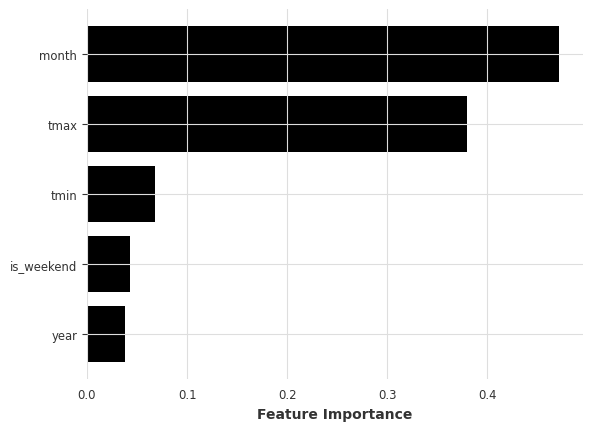

In [94]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X, y)
sort = rf.feature_importances_.argsort()
plt.barh(X.columns[sort], rf.feature_importances_[sort])
plt.xlabel("Feature Importance")

In [95]:
from scipy import stats
coef, p_val = stats.pearsonr(resulting_T_E["presences_tourists"], resulting_T_E["presences_excursionists"])
print(coef, p_val)

0.8590174850048656 1.733215975529161e-239


# DarTS Timeseries analysis

1- Example taken from the paper

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 166    | train
-------------------------------------------------------------
166       Trainable params
0         Non-trainable params
166       Total params
0.001     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 9/9 [00:00<00:00, 119.40it/s, train_loss=-1.68]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 9/9 [00:00<00:00, 117.58it/s, train_loss=-1.68]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


<Axes: xlabel='Month'>

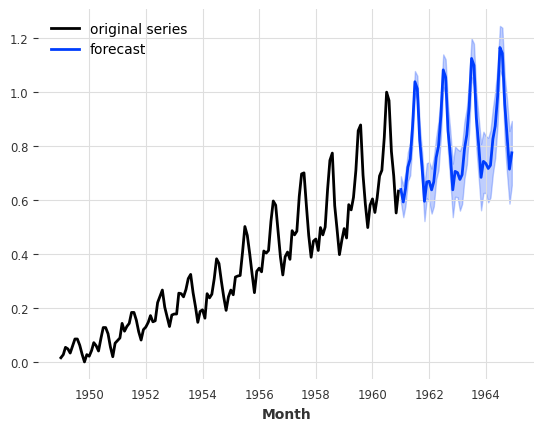

In [96]:
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset 
from darts.dataprocessing.transformers import Scaler 
from darts.models import TCNModel 
from darts.utils.likelihood_models import LaplaceLikelihood as LL 
air = AirPassengersDataset().load() 
milk = MonthlyMilkDataset().load() 
scaler_air, scaler_milk = Scaler(), Scaler() 
air_s = scaler_air.fit_transform(air) 
milk_s = scaler_milk.fit_transform(milk) 
model = TCNModel(input_chunk_length=24, output_chunk_length=12, likelihood=LL()) 
model.fit([air_s, milk_s], epochs=100) 
pred = model.predict(n=48, series=air_s, num_samples=500) 
air_s.plot(label='original series') 
pred.plot(low_quantile=.1, high_quantile=.9, label='forecast')

2- Example from the documentation

In [97]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset
from darts.models import FFT

In [98]:
training_data_T_E = resulting_T_E[["all", "date", "presences_tourists", "presences_excursionists", "is_weekend", "month", "year", "tmax", "tmin", "week"]]
resulting_ts_df = TimeSeries.from_dataframe(training_data_T_E, 
                                            time_col="date",
                                            value_cols="all")

In [99]:
training_data_T_E

,all,date,presences_tourists,presences_excursionists,is_weekend,month,year,tmax,tmin,week
0,7680,2022-01-01,4550,3130,1,1,2022,0,0.0,52
1,8036,2022-01-02,5110,2926,1,1,2022,0,0.0,52
2,5400,2022-01-03,3643,1757,0,1,2022,12,0.0,1
3,4693,2022-01-04,3337,1356,0,1,2022,0,0.0,1
4,3801,2022-01-05,3255,546,0,1,2022,2,0.0,1
...,...,...,...,...,...,...,...,...,...,...
813,752,2024-03-24,0,752,1,3,2024,10,-1.0,12
814,325,2024-03-25,0,325,0,3,2024,13,-3.0,13
815,229,2024-03-26,0,229,0,3,2024,0,0.0,13
816,317,2024-03-27,0,317,0,3,2024,11,7.0,13


In [100]:
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality

In [101]:
check_seasonality(resulting_ts_df)

(True, 7)

In [102]:
extract_trend_and_seasonality(resulting_ts_df)

(<TimeSeries (DataArray) (date: 818, component: 1, sample: 1)> Size: 7kB
 array([[[ 7620.73469388]],
 
        [[ 7066.2244898 ]],
 
        [[ 6511.71428571]],
 
        [[ 5863.28571429]],
 
        [[ 5545.71428571]],
 
        [[ 4874.        ]],
 
        [[ 4220.57142857]],
 
        [[ 3677.        ]],
 
        [[ 3273.42857143]],
 
        [[ 2601.71428571]],
 
 ...
 
        [[  817.57142857]],
 
        [[  751.14285714]],
 
        [[  661.42857143]],
 
        [[  544.85714286]],
 
        [[  400.42857143]],
 
        [[  406.28571429]],
 
        [[  391.14285714]],
 
        [[  220.69387755]],
 
        [[  139.02040816]],
 
        [[   57.34693878]]])
 Coordinates:
   * date       (date) datetime64[ns] 7kB 2022-01-01 2022-01-02 ... 2024-03-28
   * component  (component) <U1 4B '0'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 <TimeSeries (DataArray) (date: 818, component: 1, sample: 1)> Size: 7kB
 a

In [103]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [107]:
presences_2023_df

,all,date,presences_tourists,presences_excursionists,is_weekend,month,year,tmax,tmin,week
365,7045,2023-01-01,4065,2980,1,1,2023,0,0.0,52
366,5471,2023-01-02,3180,2291,0,1,2023,8,4.0,1
367,5508,2023-01-03,3248,2260,0,1,2023,8,2.0,1
368,6467,2023-01-04,3505,2962,0,1,2023,0,0.0,1
369,6794,2023-01-05,3737,3057,0,1,2023,9,-3.0,1
...,...,...,...,...,...,...,...,...,...,...
725,2536,2023-12-27,620,1916,0,12,2023,0,0.0,52
726,3091,2023-12-28,617,2474,0,12,2023,5,-1.0,52
727,3257,2023-12-29,608,2649,0,12,2023,5,2.0,52
728,4182,2023-12-30,641,3541,1,12,2023,8,1.0,52


In [108]:
stats_df_2023 = presences_2023_df[["date", "presences_tourists", "presences_excursionists"]].set_index("date")
stats_df_2023

,presences_tourists,presences_excursionists
date,,
2023-01-01,4065,2980
2023-01-02,3180,2291
2023-01-03,3248,2260
2023-01-04,3505,2962
2023-01-05,3737,3057
...,...,...
2023-12-27,620,1916
2023-12-28,617,2474
2023-12-29,608,2649


In [109]:
adf_test(presences_2023_df["presences_tourists"])

Results of Dickey-Fuller Test:
Test Statistic                  -1.682666
p-value                          0.440065
#Lags Used                      16.000000
Number of Observations Used    348.000000
Critical Value (1%)             -3.449282
Critical Value (5%)             -2.869881
Critical Value (10%)            -2.571214
dtype: float64


In [110]:
kpss_test(presences_2023_df["presences_excursionists"])

Results of KPSS Test:
Test Statistic            0.357387
p-value                   0.095523
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


## Trend determination and detect seasonality

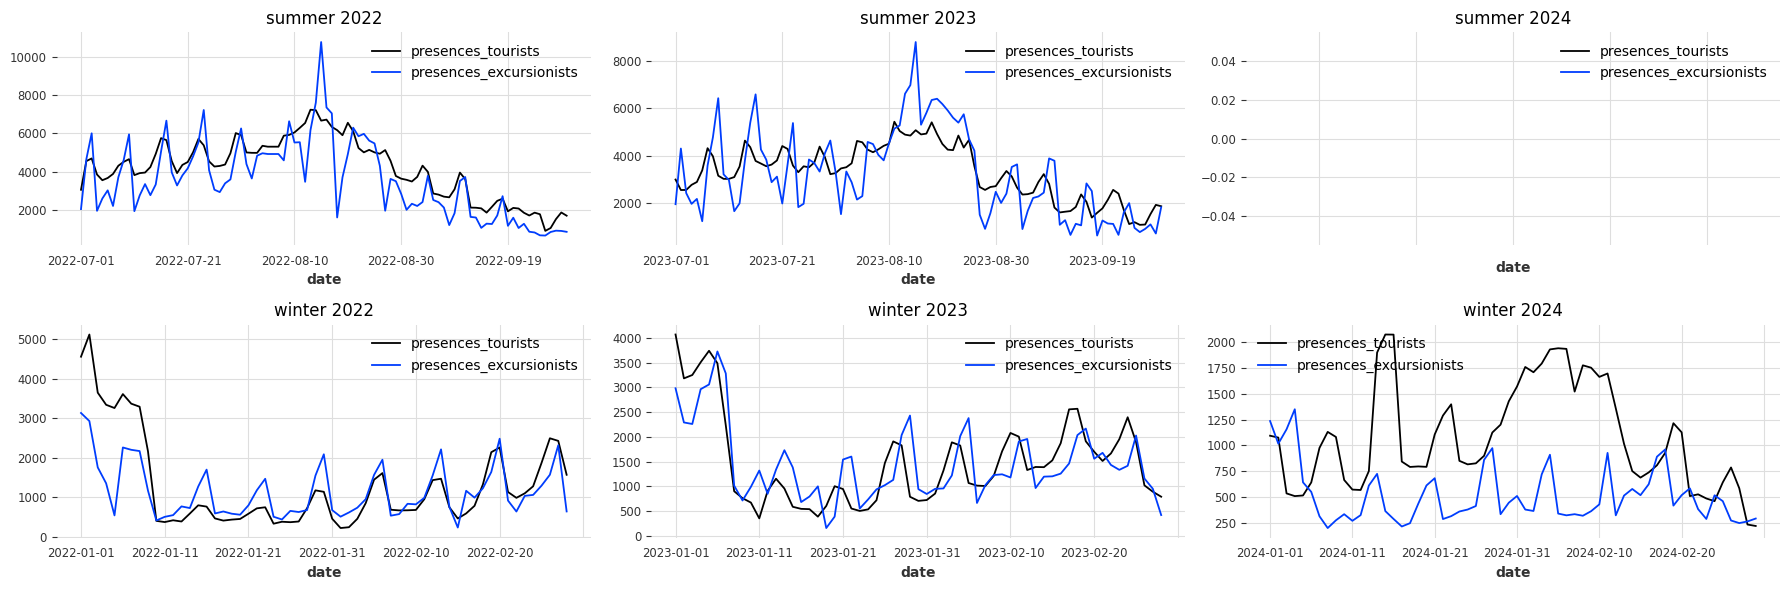

In [152]:
###############################  Global Trends
presences_2022_df = training_data_T_E[training_data_T_E["year"] == 2022]
presences_2023_df = training_data_T_E[training_data_T_E["year"] == 2023]
presences_2024_df = training_data_T_E[training_data_T_E["year"] == 2024]

###############################  Local Trends - Seasonal Components
########### summer seasonal component
summer_trend_2022_df = presences_2022_df[presences_2022_df["month"].isin([7, 8, 9])]
summer_trend_2023_df = presences_2023_df[presences_2023_df["month"].isin([7, 8, 9])]
summer_trend_2024_df = presences_2024_df[presences_2024_df["month"].isin([7, 8, 9])]
#summer_trend_2023_df.plot(x="date", y="presences_tourists")
########### winter seasonal component
winter_trend_2022_df = training_data_T_E[ (training_data_T_E["year"] == 2022) & (training_data_T_E["month"].isin([1, 2]))]
winter_trend_2023_df = training_data_T_E[ (training_data_T_E["year"] == 2023) & (training_data_T_E["month"].isin([1, 2]))]
winter_trend_2024_df = training_data_T_E[ (training_data_T_E["year"] == 2024) & (training_data_T_E["month"].isin([1, 2]))]

########### weather trend component  TODO
# good_weather_df
# bad_weather

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,6))
summer_trend_2022_df.plot(x="date", y=["presences_tourists", "presences_excursionists"], ax=axs[0, 0], title="summer 2022")
summer_trend_2023_df.plot(x="date", y=["presences_tourists", "presences_excursionists"], ax=axs[0, 1], title="summer 2023")
summer_trend_2024_df.plot(x="date", y=["presences_tourists", "presences_excursionists"], ax=axs[0, 2], title="summer 2024")

winter_trend_2022_df.plot(x="date", y=["presences_tourists", "presences_excursionists"], ax=axs[1, 0], title="winter 2022")
winter_trend_2023_df.plot(x="date", y=["presences_tourists", "presences_excursionists"], ax=axs[1, 1], title="winter 2023")
winter_trend_2024_df.plot(x="date", y=["presences_tourists", "presences_excursionists"], ax=axs[1, 2], title="winter 2024")
fig.tight_layout()

<Axes: xlabel='date'>

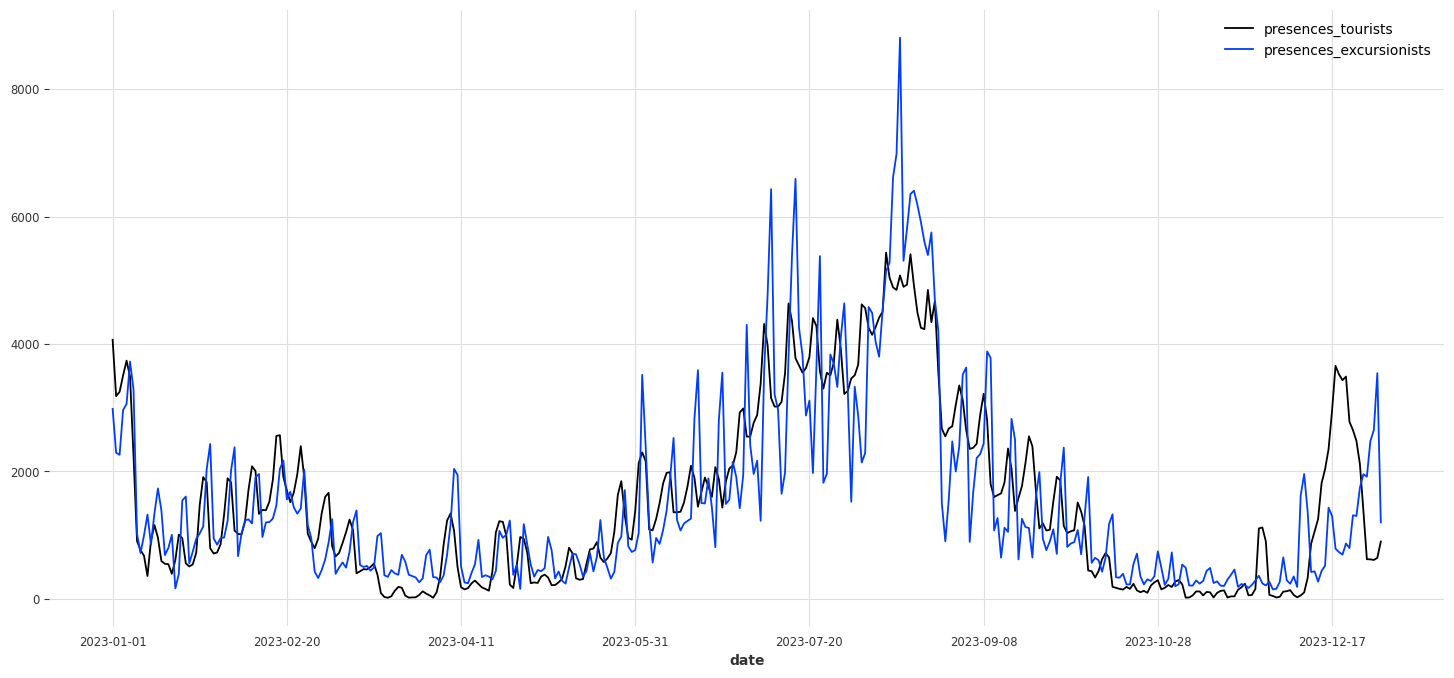

In [111]:
presences_2023_df.plot(x="date", y=["presences_tourists", "presences_excursionists"], figsize=(18, 8))

Convert season components into time series

In [112]:
presences_2022_tourists_ts = TimeSeries.from_dataframe(presences_2022_df, time_col="date", value_cols="presences_tourists")
presences_2023_tourists_ts = TimeSeries.from_dataframe(presences_2023_df, time_col="date", value_cols="presences_excursionists")
########### summer seasonal component
summer_trend_2022_tourists_ts = TimeSeries.from_dataframe(summer_trend_2022_df, time_col="date", value_cols="presences_tourists")
summer_trend_2022_excursionists_ts = TimeSeries.from_dataframe(summer_trend_2022_df, time_col="date", value_cols="presences_excursionists")
summer_trend_2023_tourists_ts = TimeSeries.from_dataframe(summer_trend_2023_df, time_col="date", value_cols="presences_tourists")
summer_trend_2023_excursionists_ts = TimeSeries.from_dataframe(summer_trend_2023_df, time_col="date", value_cols="presences_excursionists")
#summer_trend_2024_tourists_ts = TimeSeries.from_dataframe(summer_trend_2024_df, time_col="date", value_cols="presences_tourists", fill_missing_dates=True)
#summer_trend_2024_excursionists_ts = TimeSeries.from_dataframe(summer_trend_2024_df, time_col="date", value_cols="presences_excursionists", fill_missing_dates=True)

########### winter seasonal component
winter_trend_2022_tourists_ts = TimeSeries.from_dataframe(winter_trend_2022_df, time_col="date", value_cols="presences_tourists")
winter_trend_2022_excursionists_ts = TimeSeries.from_dataframe(winter_trend_2022_df, time_col="date", value_cols="presences_excursionists")
winter_trend_2023_tourists_ts = TimeSeries.from_dataframe(winter_trend_2023_df, time_col="date", value_cols="presences_tourists")
winter_trend_2023_excursionists_ts = TimeSeries.from_dataframe(winter_trend_2023_df, time_col="date", value_cols="presences_excursionists")
#winter_trend_2024_tourists_ts = TimeSeries.from_dataframe(winter_trend_2024_df, time_col="date", value_cols="presences_tourists", fill_missing_dates=True)
#winter_trend_2024_excursionists_ts = TimeSeries.from_dataframe(winter_trend_2024_df, time_col="date", value_cols="presences_excursionists", fill_missing_dates=True)

## Predicting

Automatically detect the seasonal periods, uses the 10 most significant frequencies for
forecasting and expect no global trend to be present in the data:

In [114]:
from darts.datasets import AirPassengersDataset
from darts.models import FFT
# increase the number of frequency and use a polynomial trend of degree 2
model = FFT(
    nr_freqs_to_keep=20,
    trend= "poly",
    trend_poly_degree=2
)
model.fit(resulting_ts_df)
pred = model.predict(300)
#pred.values()

<Axes: xlabel='date'>

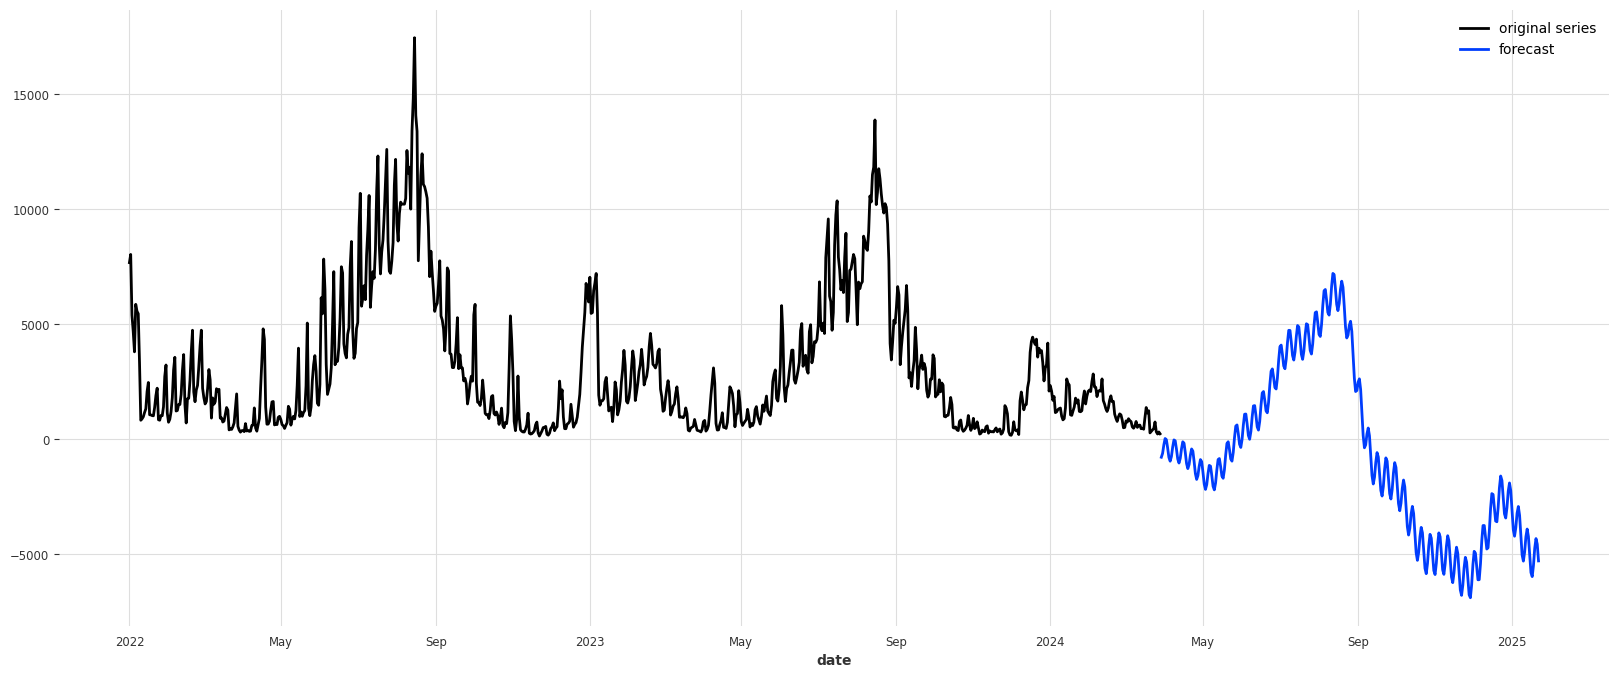

In [115]:
plt.figure(figsize=(20, 8))
resulting_ts_df.plot(label='original series') 
pred.plot(label='forecast') #low_quantile=.1, high_quantile=.9, 

## Detrending

<Axes: xlabel='date'>

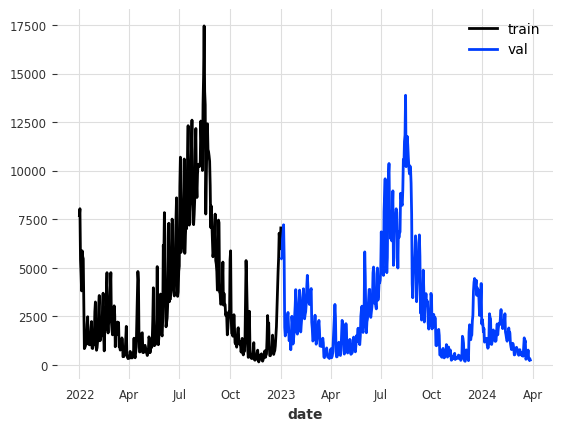

In [679]:
train, val = resulting_ts_df.split_after(pd.Timestamp("20230101"))
train.plot(label="train")
val.plot(label="val")

### Option 1: No detrending

<Axes: xlabel='date'>

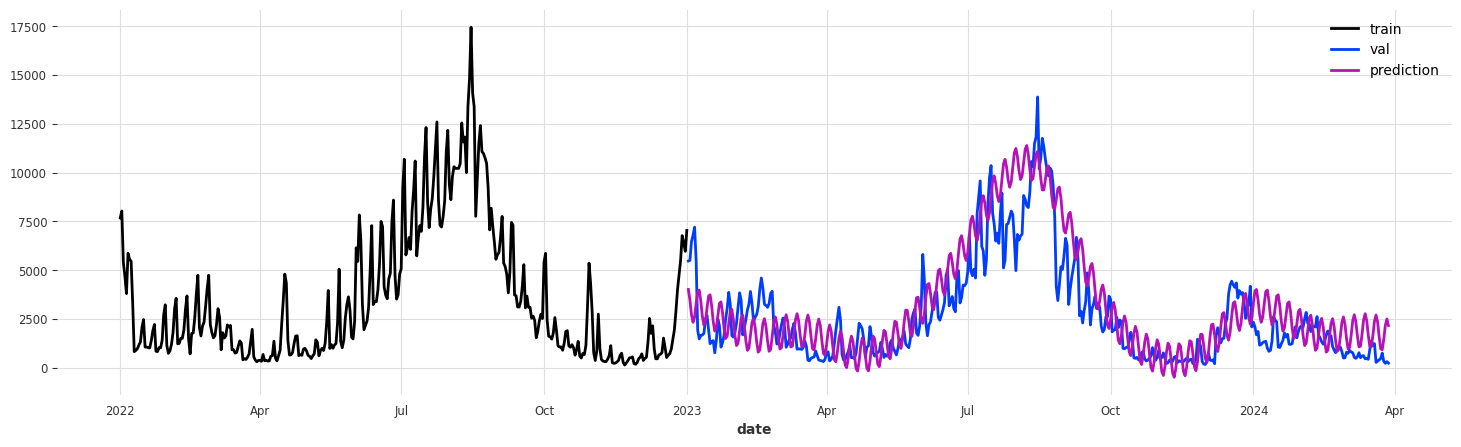

In [680]:
model = FFT()
model.fit(train)
pred_val = model.predict(len(val))
plt.figure(figsize=(18, 5))
train.plot(label="train")
val.plot(label="val")
pred_val.plot(label="prediction")

### Option 2: With detrending

Expoential smoothing

<Axes: xlabel='date'>

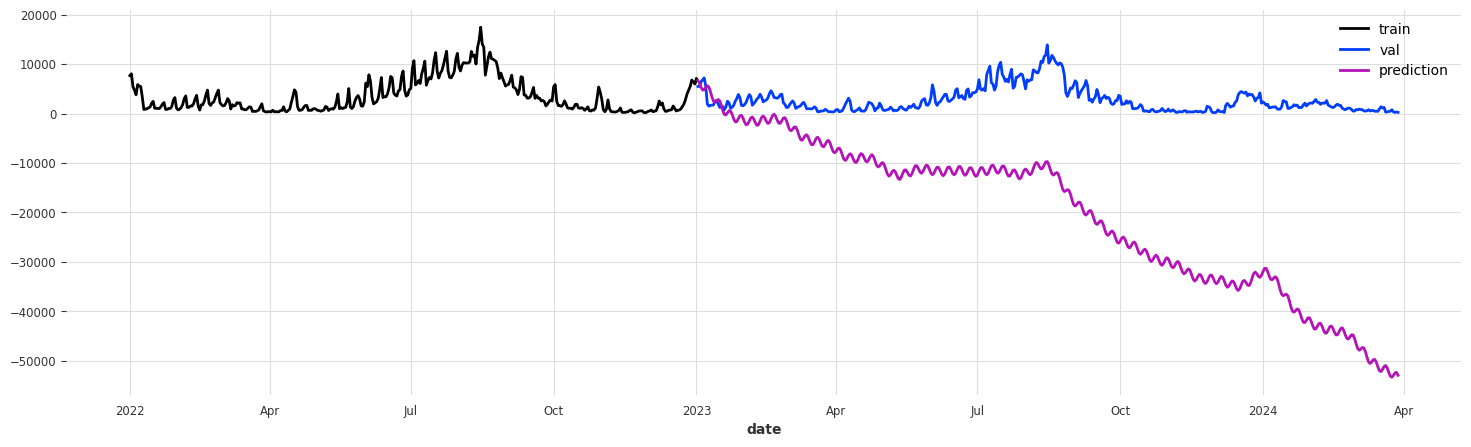

In [682]:
model = FFT(
    nr_freqs_to_keep=20,
    trend= "poly",
    trend_poly_degree=2
)
model.fit(train)
pred_val = model.predict(len(val))
plt.figure(figsize=(18, 5))
train.plot(label="train")
val.plot(label="val")
pred_val.plot(label="prediction")

### Variants (methods to capture seasonality)

<Axes: xlabel='date'>

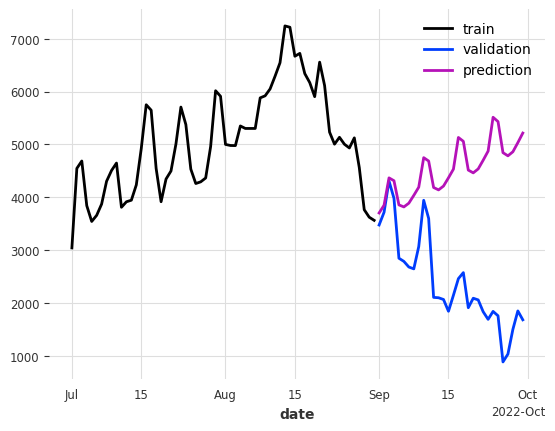

In [684]:
from darts.datasets import AirPassengersDataset
from darts.models import ExponentialSmoothing
from darts.utils.utils import ModelMode, SeasonalityMode
train, val = summer_trend_2022_tourists_ts.split_after(pd.Timestamp("20220831"))

# using Holt's exponential smoothing
model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.MULTIPLICATIVE)
model.fit(train)
pred = model.predict(len(val))
train.plot(label="train")
val.plot(label="validation")
pred.plot(label="prediction")

<Axes: xlabel='date'>

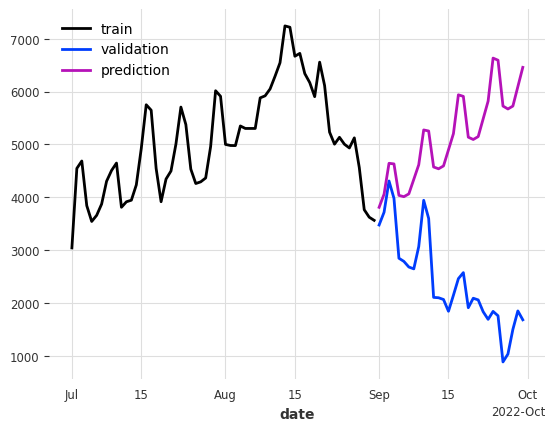

In [685]:
# using Holt's exponential smoothing
model = ExponentialSmoothing(trend=ModelMode.MULTIPLICATIVE, seasonal=SeasonalityMode.MULTIPLICATIVE, damped=True)
model.fit(train)
pred = model.predict(len(val))
train.plot(label="train")
val.plot(label="validation")
pred.plot(label="prediction")

<Axes: xlabel='date'>

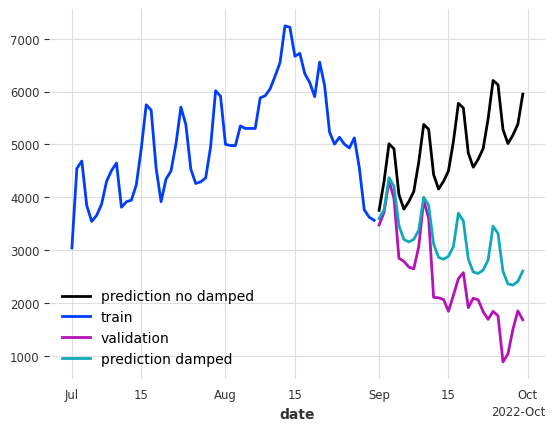

In [686]:
# using Holt's exponential smoothing
model1 = ExponentialSmoothing(trend=ModelMode.MULTIPLICATIVE, seasonal=SeasonalityMode.ADDITIVE)
model1.fit(train)
pred = model1.predict(len(val))
pred.plot(label="prediction no damped")

# using Holt's exponential smoothing
model2 = ExponentialSmoothing(trend=ModelMode.MULTIPLICATIVE, seasonal=SeasonalityMode.ADDITIVE, damped=True)
model2.fit(train)
pred = model2.predict(len(val))
train.plot(label="train")
val.plot(label="validation")
pred.plot(label="prediction damped")

In [687]:
train

<TimeSeries (DataArray) (date: 62, component: 1, sample: 1)>
array([[[3045.]],

       [[4548.]],

       [[4688.]],

       [[3844.]],

       [[3545.]],

       [[3661.]],

       [[3874.]],

       [[4305.]],

       [[4508.]],

       [[4649.]],

...

       [[5234.]],

       [[5006.]],

       [[5136.]],

       [[5005.]],

       [[4934.]],

       [[5125.]],

       [[4564.]],

       [[3767.]],

       [[3626.]],

       [[3566.]]])
Coordinates:
  * date       (date) datetime64[ns] 2022-07-01 2022-07-02 ... 2022-08-31
  * component  (component) object 'presences_tourists'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='date'>

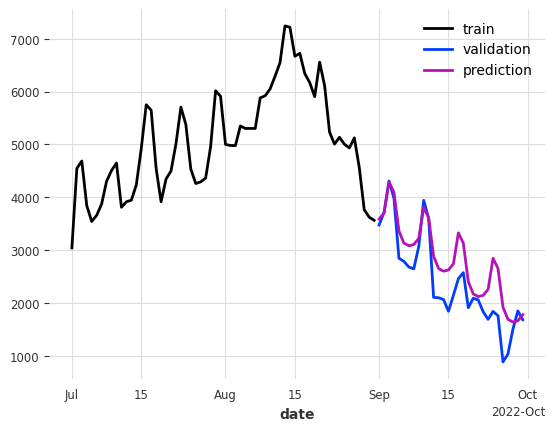

In [688]:
# using Holt's exponential smoothing
model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.ADDITIVE)
# , seasonal_periods=7
model.fit(train)
pred = model.predict(len(val))
train.plot(label="train")
val.plot(label="validation")
pred.plot(label="prediction")

# Detrending vodafone visitor attendances

<Axes: xlabel='date'>

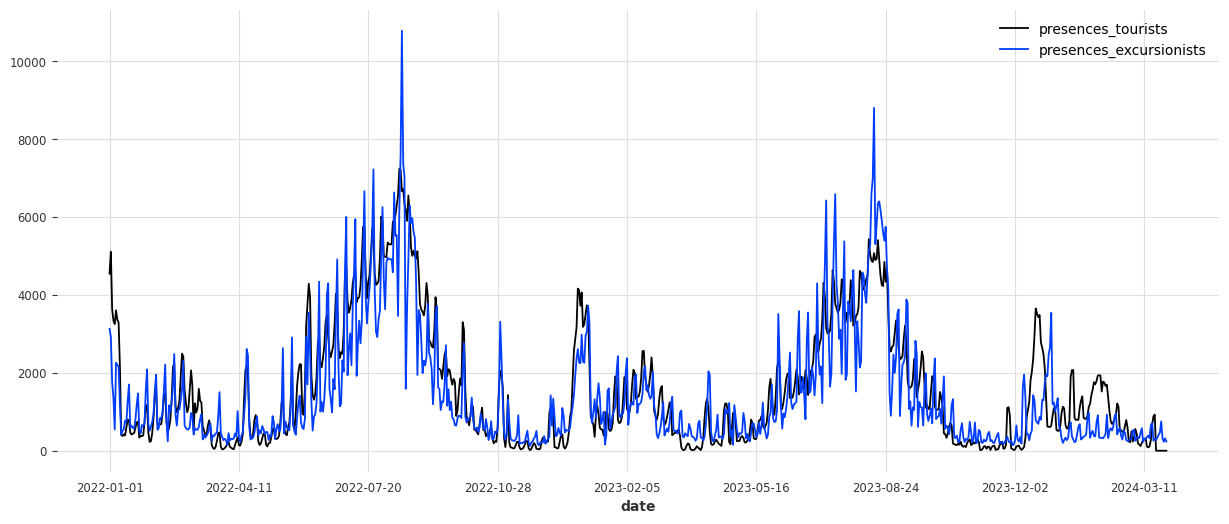

In [118]:
ax = training_data_T_E.plot(x="date", y="presences_tourists")
training_data_T_E.plot(ax=ax, x="date", y="presences_excursionists", figsize=(15,6))

## Window operations 

## Remove week seasonality

<Axes: >

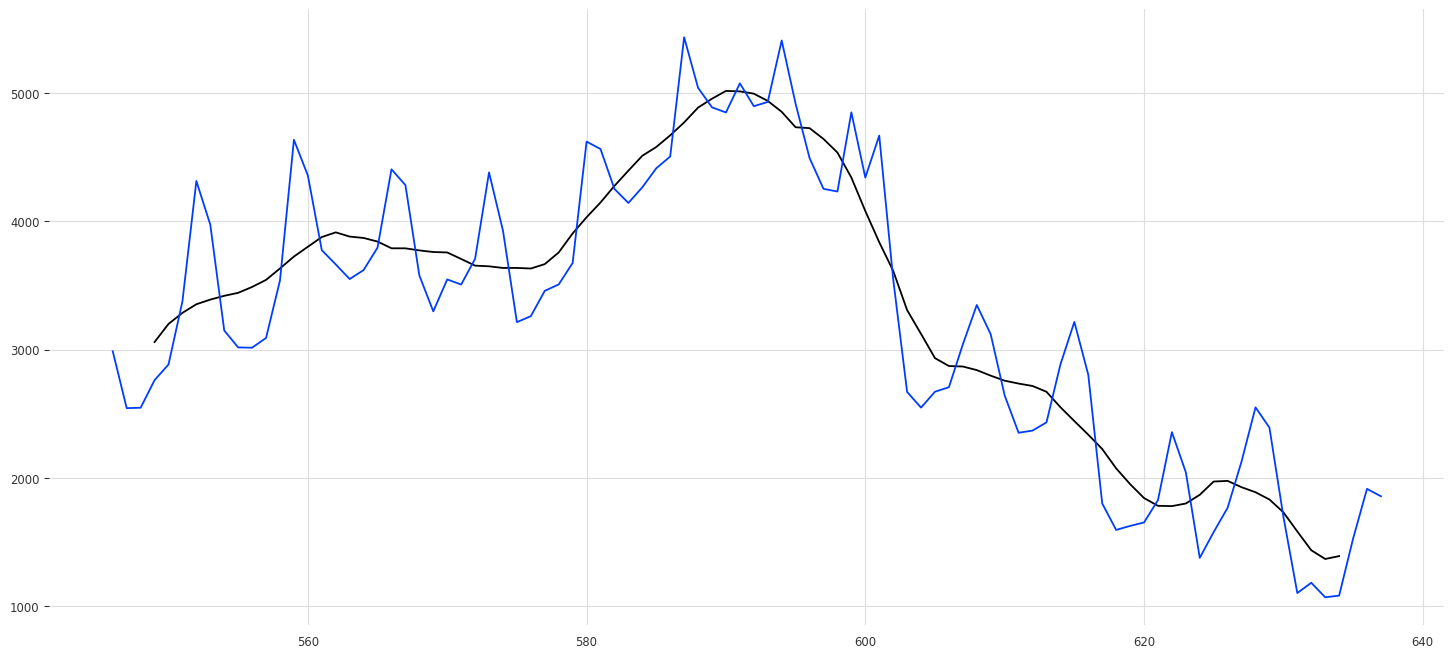

In [160]:
def detrend_ts(timeseries):
    timeseries["detrend_week_t"] = timeseries['presences_tourists'].rolling(window=7, center=True).mean()
    timeseries["detrend_week_e"] = timeseries['presences_excursionists'].rolling(window=7, center=True).mean()
    return timeseries
summer_trend_2023_df = detrend_ts(summer_trend_2023_df)
summer_trend_2022_df = detrend_ts(summer_trend_2022_df)
#rolling_mean_T = summer_trend_2023_df['presences_tourists'].rolling(window=7, center=True).mean()
#rolling_mean_E = summer_trend_2023_df['presences_excursionists'].rolling(window=7, center=True).mean()
#summer_trend_2023_df["detrend_week_t"] = rolling_mean_T
#summer_trend_2023_df["detrend_week_e"] = rolling_mean_E
#temp_T = summer_trend_2023_df['presences_tourists'] - rolling_mean_T
#temp_E = summer_trend_2023_df['presences_excursionists'] - rolling_mean_E
ax = summer_trend_2023_df["detrend_week_t"].plot()
summer_trend_2023_df['presences_tourists'].plot(ax=ax, figsize=(18, 8))

<Axes: >

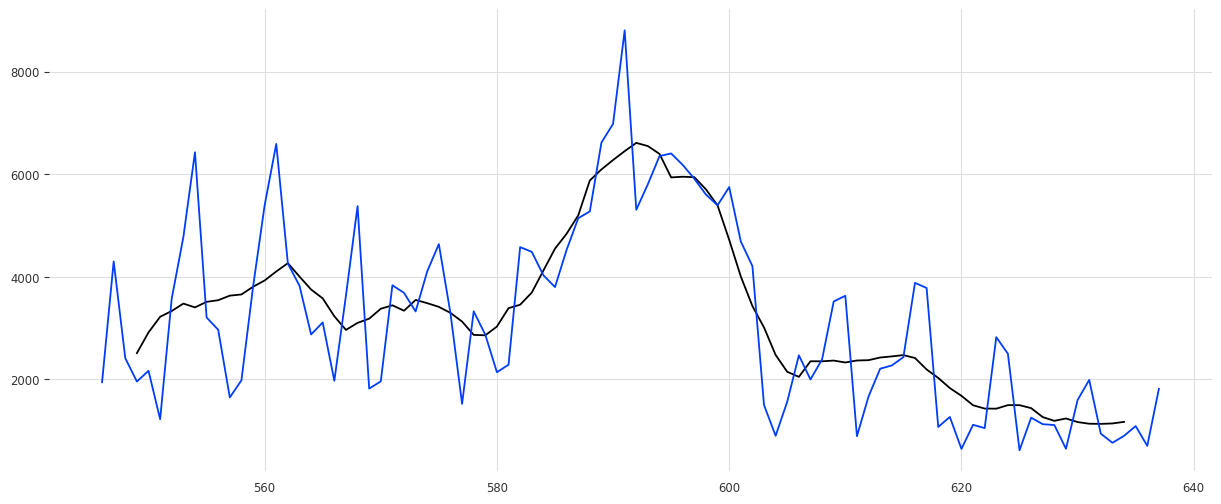

In [161]:
ax = summer_trend_2023_df["detrend_week_e"].plot(figsize=(15,6))
summer_trend_2023_df['presences_excursionists'].plot(ax=ax)

## Remove Month seasonality

<Axes: xlabel='date'>

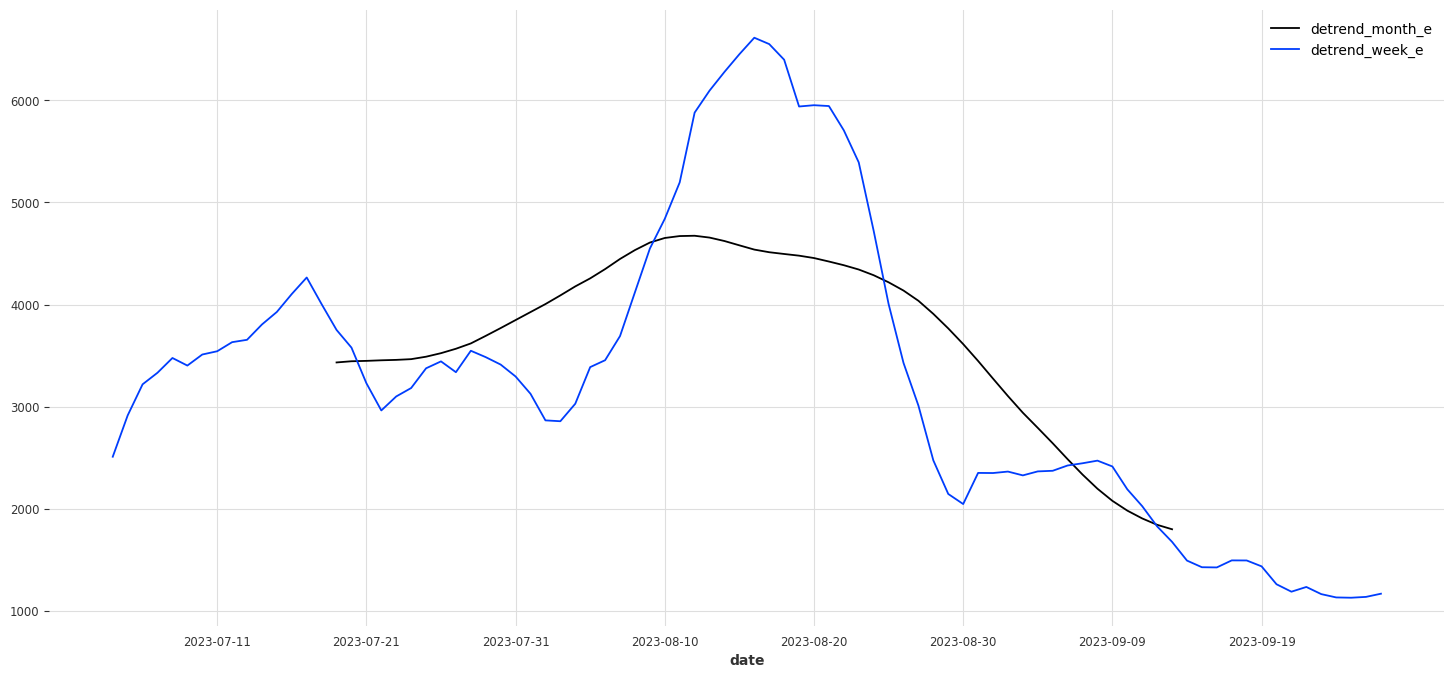

In [162]:
def detrend_month_ts(timeseries):
    timeseries["detrend_month_t"] = timeseries['detrend_week_t'].rolling(window=30, center=True).mean()
    timeseries["detrend_month_e"] = timeseries['detrend_week_e'].rolling(window=30, center=True).mean()
    return timeseries
summer_trend_2023_df = detrend_month_ts(summer_trend_2023_df)
summer_trend_2022_df = detrend_month_ts(summer_trend_2022_df)
ax = summer_trend_2023_df.plot(x="date", y="detrend_month_e")
summer_trend_2023_df.plot(ax=ax, x="date", y="detrend_week_e", figsize=(18, 8))  

In [163]:
# Consider only full weeks that result present in the dataset
full_weeks = [key for key, value in dict(summer_trend_2023_df["week"].value_counts()).items() if value==7]
full_weeks_2022 = [key for key, value in dict(summer_trend_2022_df["week"].value_counts()).items() if value==7]
full_weeks

[27, 28, 30, 29, 31, 32, 36, 33, 34, 35, 38, 37]

<Axes: xlabel='date'>

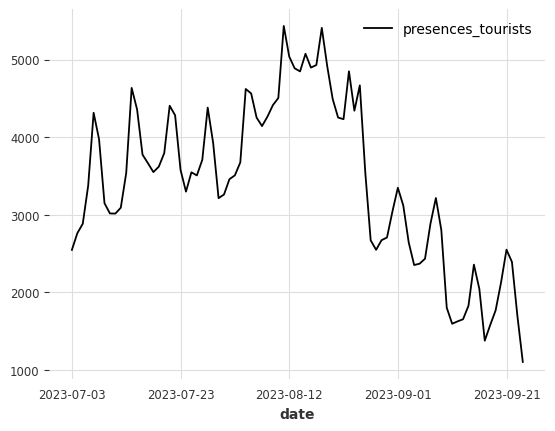

In [164]:
transformed_weeks = summer_trend_2023_df[summer_trend_2023_df["week"].isin(full_weeks)]
transformed_weeks_2022 = summer_trend_2022_df[summer_trend_2022_df["week"].isin(full_weeks_2022)]
transformed_weeks.plot(x="date", y="presences_tourists")

### Normalization

In [158]:
transformed_weeks

,all,date,presences_tourists,presences_excursionists,is_weekend,month,year,tmax,tmin,week
548,4960,2023-07-03,2547,2413,0,7,2023,0,0.0,27
549,4720,2023-07-04,2762,1958,0,7,2023,23,13.0,27
550,5051,2023-07-05,2884,2167,0,7,2023,0,0.0,27
551,4599,2023-07-06,3376,1223,0,7,2023,23,12.0,27
552,7891,2023-07-07,4314,3577,0,7,2023,0,0.0,27
...,...,...,...,...,...,...,...,...,...,...
627,3255,2023-09-20,2129,1126,0,9,2023,20,9.0,38
628,3659,2023-09-21,2550,1109,0,9,2023,0,0.0,38
629,3038,2023-09-22,2392,646,0,9,2023,15,12.0,38
630,3296,2023-09-23,1699,1597,1,9,2023,0,0.0,38


In [165]:
from sklearn.preprocessing import MinMaxScaler
def scale_timeframe(transformed_weeks):    
    scaler = MinMaxScaler()
    transformed_weeks["presences_tourists_scaled"] = scaler.fit_transform(transformed_weeks[["presences_tourists"]])
    transformed_weeks["presences_excursionists_scaled"] = scaler.fit_transform(transformed_weeks[["presences_excursionists"]])
    transformed_weeks["detrend_week_t_scaled"] = scaler.fit_transform(transformed_weeks[["detrend_week_t"]])
    transformed_weeks["detrend_week_e_scaled"] = scaler.fit_transform(transformed_weeks[["detrend_week_e"]])
    transformed_weeks["detrend_month_t_scaled"] = scaler.fit_transform(transformed_weeks[["detrend_month_t"]])
    transformed_weeks["detrend_month_e_scaled"] = scaler.fit_transform(transformed_weeks[["detrend_month_e"]])
    return transformed_weeks
transformed_weeks_2023 = scale_timeframe(transformed_weeks)
transformed_weeks_2022 = scale_timeframe(transformed_weeks_2022)

<Axes: xlabel='date'>

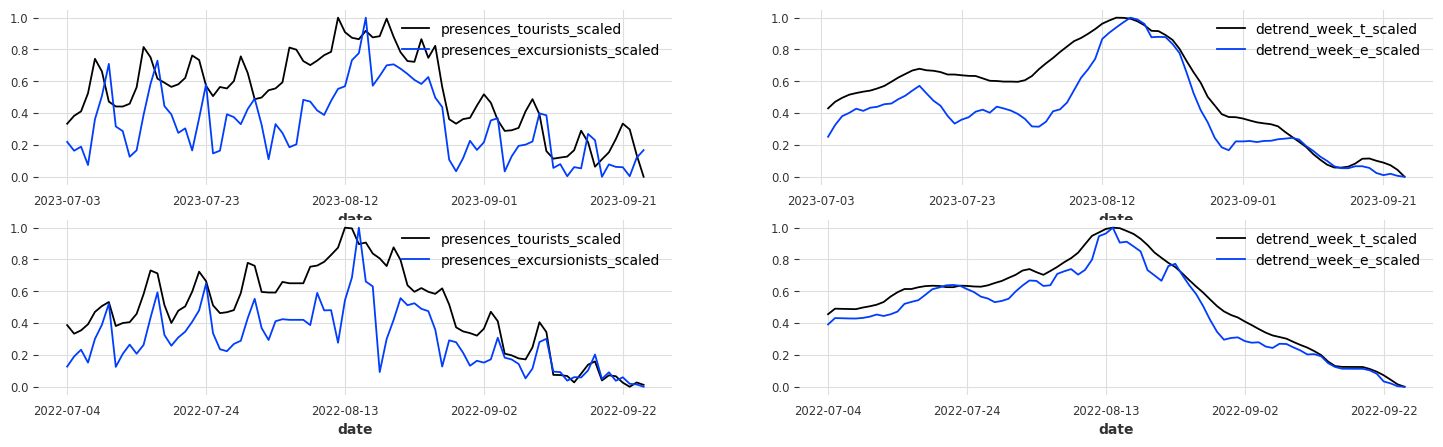

In [166]:
figs, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 5))
transformed_weeks_2023.plot(x="date", y=["presences_tourists_scaled", "presences_excursionists_scaled"], ax=axs[0, 0])
transformed_weeks_2023.plot(x="date", y=["detrend_week_t_scaled", "detrend_week_e_scaled"], ax=axs[0, 1])
transformed_weeks_2022.plot(x="date", y=["presences_tourists_scaled", "presences_excursionists_scaled"], ax=axs[1, 0])
transformed_weeks_2022.plot(x="date", y=["detrend_week_t_scaled", "detrend_week_e_scaled"], ax=axs[1, 1])

<Axes: title={'center': '2023'}, xlabel='date'>

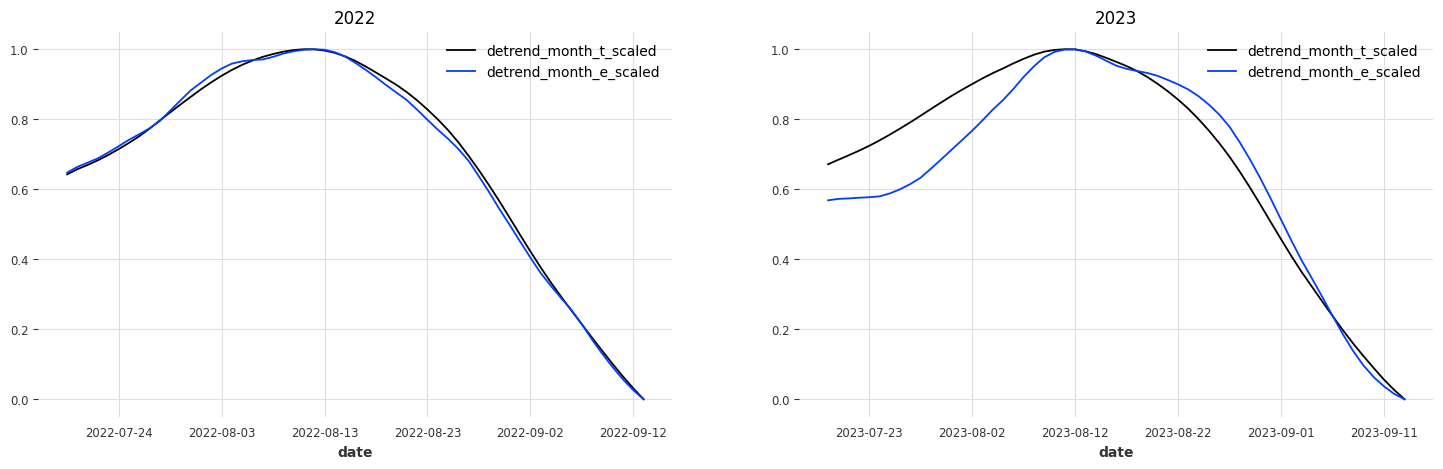

In [172]:
figs, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
transformed_weeks_2022.plot(x="date", y=["detrend_month_t_scaled", "detrend_month_e_scaled"], ax=axs[0], title="2022")
transformed_weeks_2023.plot(x="date", y=["detrend_month_t_scaled", "detrend_month_e_scaled"], ax=axs[1], title="2023")

<Axes: xlabel='date'>

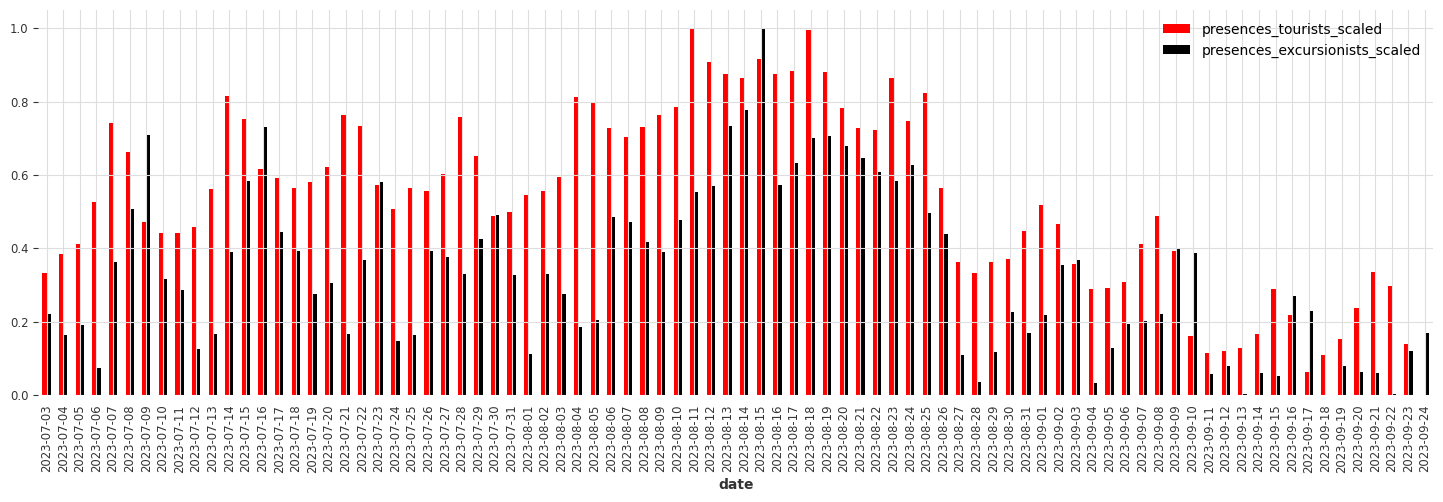

In [891]:
transformed_weeks_2023.plot(x="date", y=["presences_tourists_scaled", "presences_excursionists_scaled"], 
                       figsize=(18, 5), kind="bar", 
                       color=["red", "black"])
#transformed_weeks.plot(x="date", y="presences_excursionists_scaled", ax=ax, kind="bar", color="red")

In [892]:
for key, group in transformed_weeks_2023.groupby("week"):
    t_color = random.choice(list(mcolors.CSS4_COLORS.keys()))
    e_color = random.choice(list(mcolors.CSS4_COLORS.keys()))
    #group.plot(x="date", y=["presences_tourists_scaled"], 
    #                   figsize=(18, 5), kind="bar", 
    #                   color=[t_color, e_color])

### Model selection

Fast Fourier Transform Model

<Axes: xlabel='date'>

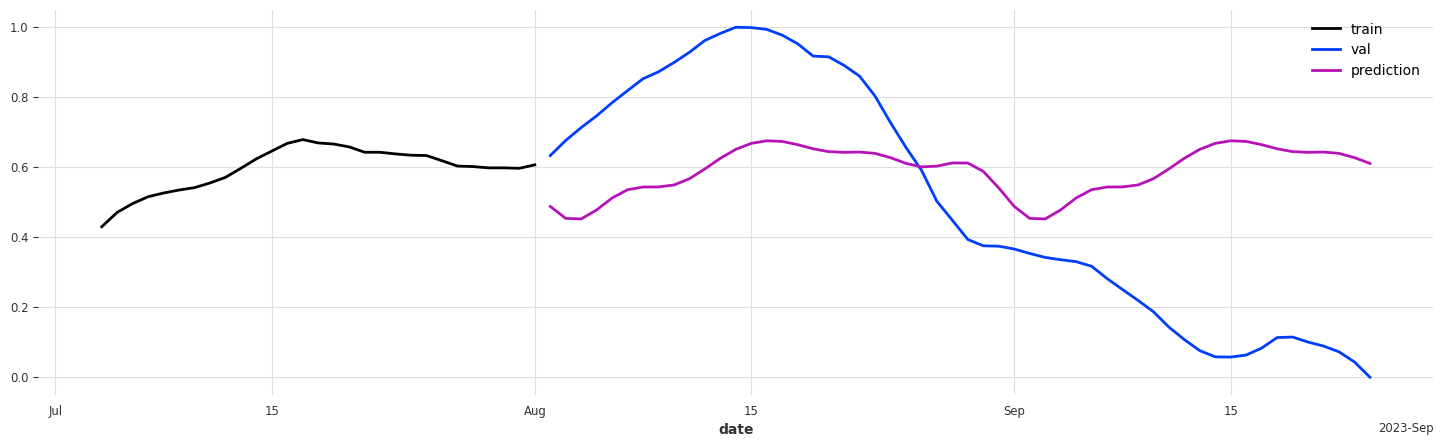

In [894]:
res_week_ts_2022_df = TimeSeries.from_dataframe(transformed_weeks_2022, time_col="date", value_cols="detrend_week_t_scaled")
res_week_ts_2023_df = TimeSeries.from_dataframe(transformed_weeks_2023, time_col="date", value_cols="detrend_week_t_scaled")

train, val = res_week_ts_2023_df.split_after(pd.Timestamp("20230801"))
model = FFT(
    #nr_freqs_to_keep=20,
    #trend= "poly",
    #trend_poly_degree=2
)
model.fit(train)
pred_val = model.predict(len(val))
plt.figure(figsize=(18, 5))
train.plot(label="train")
val.plot(label="val")
pred_val.plot(label="prediction")

In [25]:
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import MissingValuesFiller, Scaler
from darts.metrics import r2_score
from darts.models import NBEATSModel

<Axes: xlabel='date'>

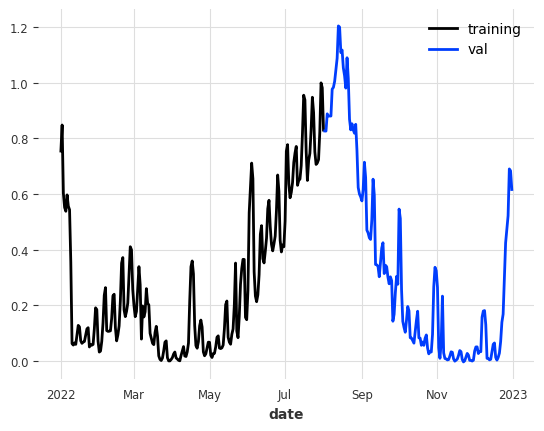

In [126]:
scaler = Scaler()
train, val = presences_2022_tourists_ts.split_after(pd.Timestamp("20220801"))

train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(presences_2022_tourists_ts)

train_scaled.plot(label="training")
val_scaled.plot(label="val")

In [24]:
from scipy.signal import detrend

In [879]:
from darts.utils.callbacks import TFMProgressBar
import logging
logging.disable(logging.CRITICAL)
def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("forecasts"))
    plt.title(f"R2: {r2_score(ts_transformed.univariate_component(0), pred_series)}")
    plt.legend()
    

In [867]:
model_name = "nbeats_interpretable_run"
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=False,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    random_state=42,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    **generate_torch_kwargs(),
)

In [868]:
model_nbeats.fit(series=train_scaled, val_series=val_scaled)

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s, train_loss=0.00108, val_loss=0.016]  


NBEATSModel(output_chunk_shift=0, generic_architecture=False, num_stacks=30, num_blocks=3, num_layers=4, layer_widths=512, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=30, output_chunk_length=7, n_epochs=100, nr_epochs_val_period=1, batch_size=800, random_state=42, model_name=nbeats_interpretable_run, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7181f51441f0>]})

In [869]:
model_nbeats = NBEATSModel.load_from_checkpoint(model_name=model_name, best=True)

In [874]:
pred_series = model_nbeats.historical_forecasts(
    series_scaled,
    start=val_scaled.start_time(),
    forecast_horizon=7,
    stride=7,
    last_points_only=False,
    retrain=False,
    verbose=True,
)
pred_series = concatenate(pred_series)

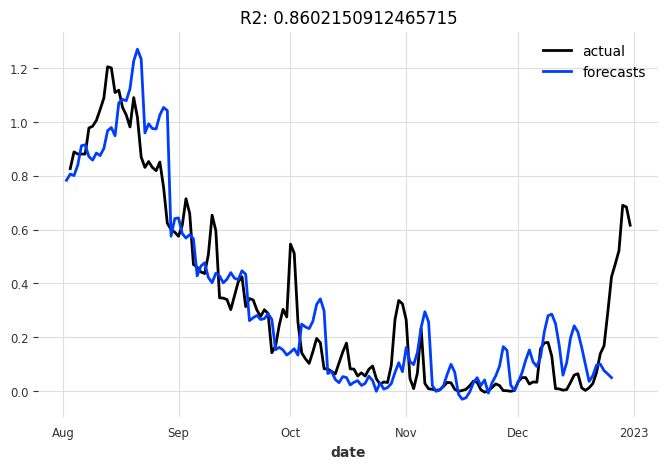

In [880]:
display_forecast(
    pred_series, series_scaled, "17 day", start_date=val_scaled.start_time()
)

Multiple timeseries (2022, 2023) - NBEATS model


In [821]:
from darts.models import NBEATSModel

train_sets = [res_week_ts_2022_df, res_week_ts_df]
multimodel =  NBEATSModel(
        input_chunk_length=24,
        output_chunk_length=12,
        n_epochs=10,
        random_state=0
    )

multimodel.fit(train_sets)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 4/4 [00:00<00:00, 13.27it/s, train_loss=nan.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:00<00:00, 13.21it/s, train_loss=nan.0]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=10, random_state=0)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.76it/s]


<Axes: xlabel='date'>

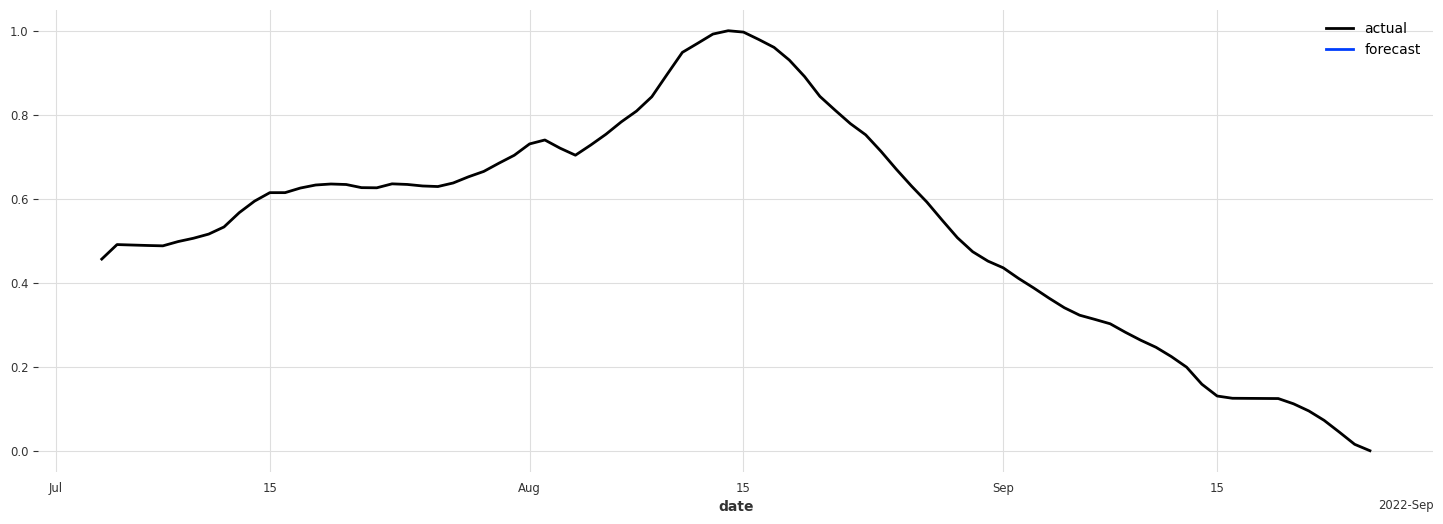

In [829]:
pred = multimodel.predict(n=34, series=train_sets[1][:-34])

plt.figure(figsize=(18, 6))
train_sets[0].plot(label="actual")
pred.plot(label="prediction")

<Axes: xlabel='date'>

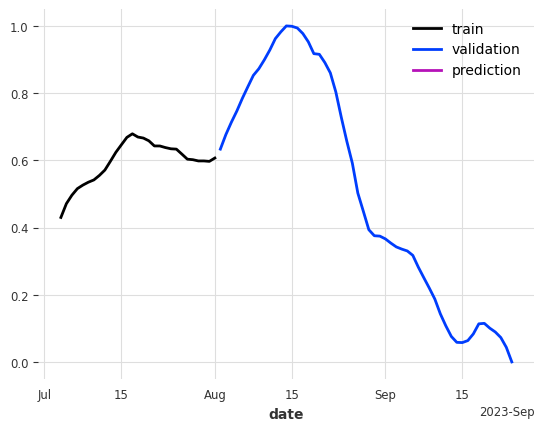

In [777]:
model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.ADDITIVE)
model.fit(train)
pred = model.predict(len(val))
train.plot(label="train")
val.plot(label="validation")
pred.plot(label="prediction")

# Split tourists presences

In [212]:
weeks_list = [{"week_type": "low", "week_start": "2023-09-02", "week_end": "2023-09-12"}, 
              {"week_type": "medium", "week_start": "2023-07-15", "week_end": "2023-07-24"}, 
              {"week_type": "high", "week_start": "2023-08-08", "week_end": "2023-08-23"}]
def compute_stats(attendences_df, weeks, feature):
    presences_stats = {}  
    for week in weeks:
        sample = attendences_df[(attendences_df['date']>=week["week_start"]) & (attendences_df['date']<=week["week_end"])][[feature]]
        (mean, std) = (sample.mean()[feature], sample.std()[feature])
        presences_stats[week["week_type"]] = {'mean':mean, 'std':std}
    
    return presences_stats
tourist_presences_stats = compute_stats(training_data_T_E, weeks_list, "presences_tourists")
excursionist_presences_stats = compute_stats(training_data_T_E, weeks_list, "presences_excursionists")
tourist_presences_stats

{'low': {'mean': 2440.181818181818, 'std': 568.4921843230245},
 'medium': {'mean': 3832.4, 'std': 382.01721892547664},
 'high': {'mean': 4777.875, 'std': 382.0395921890819}}

In [213]:
tourist_sample_w = {}
excursionist_sample_w = {}
sample_size = 100
classes = ["low", "medium", "high"]

for cat in classes:
    stats = tourist_presences_stats[cat]
    tourist_sample_w[cat] = truncnorm.rvs(-stats['mean'] / stats['std'], 10, loc=stats['mean'], scale=stats['std'], size=sample_size)
    stats = excursionist_presences_stats[cat]
    excursionist_sample_w[cat] = truncnorm.rvs(-stats['mean'] / stats['std'], 10, loc=stats['mean'], scale=stats['std'], size=sample_size)

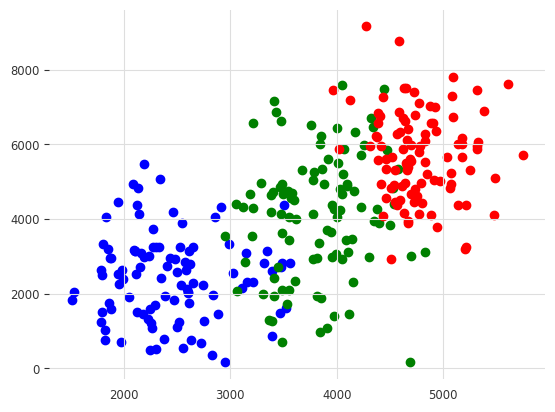

In [214]:
plt.scatter(tourist_sample_w["low"], excursionist_sample_w["low"], label="low", color="blue")
plt.scatter(tourist_sample_w["medium"], excursionist_sample_w["medium"], label="medium", color="green")
plt.scatter(tourist_sample_w["high"], excursionist_sample_w["high"], label="high", color="red")

This approach works well for data with a linear trend. If the trend is quadratic (the change in the trend also increases or decreases), then a difference of the already-differenced dataset can be taken, a second level of differencing. This process can be further repeated if needed.

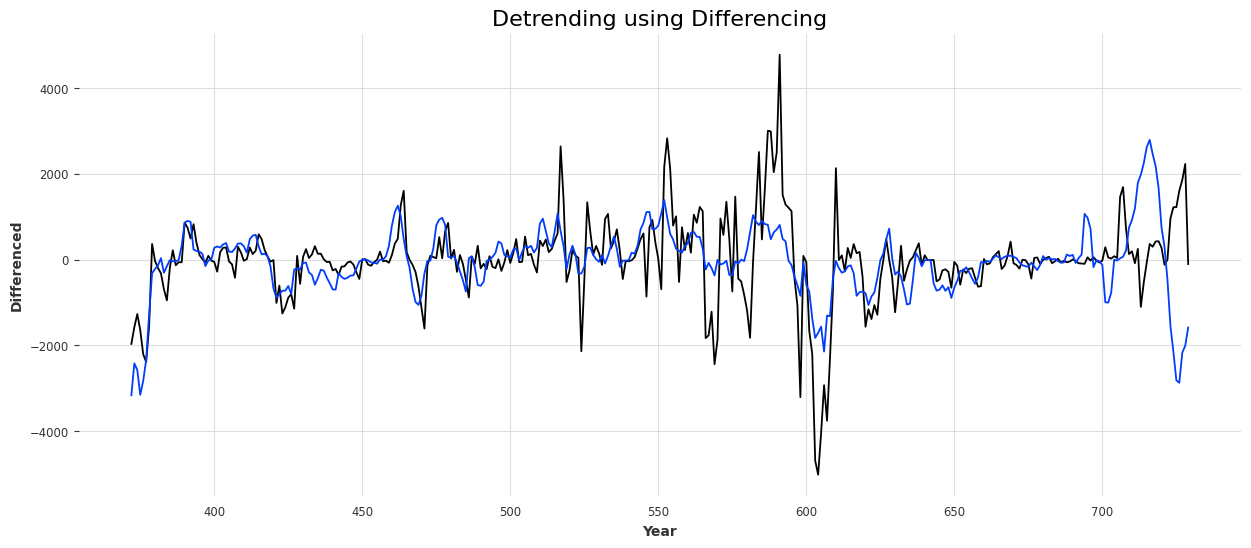

In [133]:
plt.figure(figsize=(15,6))
plt.plot(presences_2023_df["presences_excursionists"].diff(periods=7))
plt.plot(presences_2023_df["presences_tourists"].diff(periods=7))
plt.title('Detrending using Differencing', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Differenced')
plt.legend(loc="upper left")
plt.show()

# Weather seasonal decomposition

## Good weather

## Bad weather

# Important Notes
- Confounding factors are variables that influence both the independent and dependent variables, creating a potential spurious association. It’s crucial to identify and control for these variables to prevent bias in statistical analysis.
- By understanding and properly handling confounding factors, we can make more accurate and meaningful inferences from our data, leading to more effective decisions and actions.
- Causal inference methods like uplift modeling, propensity score matching (PSM), and Difference in Differences (DID) are often discussed, but their practical application in real-world work environments, particularly in supporting decision-making, is less frequently explored
- Confounding is a causal concept 